## Idea
+ Architecture
    + FFT
    + Mel scale
    + Conv stack - stride 2
    + Put each channel through the stack
    + Fro each note, divide one channel by the other to get l/r data for each note

In [1]:
from onsets_and_frames import *
import torchaudio as ta

In [2]:
from IPython.display import Audio
from fastprogress.fastprogress import master_bar, progress_bar

In [3]:
from fastai import *
from fastai.vision import *

## Default Values

``` Python
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
ONSET_LENGTH = SAMPLE_RATE * 32 // 1000
OFFSET_LENGTH = SAMPLE_RATE * 32 // 1000
HOPS_IN_ONSET = ONSET_LENGTH // HOP_LENGTH
HOPS_IN_OFFSET = OFFSET_LENGTH // HOP_LENGTH
MIN_MIDI = 21
MAX_MIDI = 108
N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2
WINDOW_LENGTH = 2048
```

In [4]:
ds = MAESTRO(path='/home/zach/Data/maestro-v2.0.0', groups=["2004", "2006", "2009", "2011"], sequence_length=100000, device='cpu')

Loading 4 groups of MAESTRO at /home/zach/Data/maestro-v2.0.0


In [5]:
train_len = int(round(0.8*len(ds)))
train_ds, valid_ds = torch.utils.data.random_split(ds, [train_len, len(ds)-train_len])
train_dl, valid_dl = [DataLoader(ds, batch_size=128, shuffle=True, num_workers=6) for ds in [train_ds, valid_ds]]

### Note
Piano starts at MIDI note 21 and goes to 108 so this dataset will only cover that range

In [6]:
plt.rcParams['figure.figsize'] = 9, 16

In [7]:
ex = next(iter(ds))
ex['label'].shape

torch.Size([195, 88])

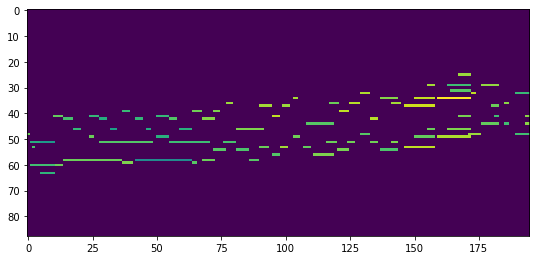

In [8]:
plt.imshow(ex['velocity'].T.flip(0))

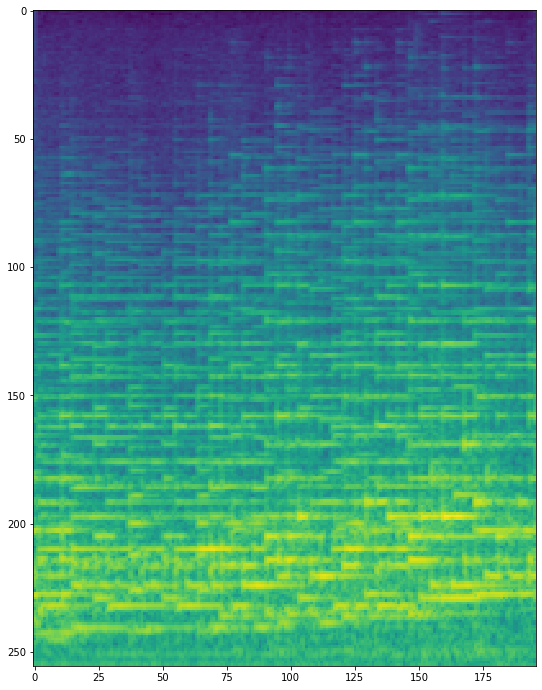

In [9]:
plt.imshow(melspectrogram.cpu()(ex['audio'].unsqueeze(0)).squeeze(0).flip(0))

In [10]:
Audio(ex['audio'].cpu()[:100000], rate=16000)

## Model

In [1]:
%%writefile note_model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

def encoder_block(sizes, i, kernel_size, padding):
    return nn.Sequential(
        nn.Conv1d(sizes[i-1][1], sizes[i][1], kernel_size, 2, padding, dilation=1),
        nn.BatchNorm1d(sizes[i][1]),
        nn.Tanh(),
        nn.Dropout(0.1)
    )

class Audio2Midi(nn.Module):
    def __init__(self, kernel_size):
        super(Audio2Midi, self).__init__()
        sizes = [(256, 64), (128, 128), (64, 64), (32, 32), (16, 16)]
        self.sizes = sizes
        padding = kernel_size // 2
        self.input = nn.Conv1d(1, sizes[0][1], kernel_size, 1, padding)
        
        self.encoder = nn.Sequential(
            *[encoder_block(sizes, i, kernel_size, padding) for i in range(1, len(sizes))]
        )
        
        self.linear = nn.Linear(sizes[-1][0]*sizes[-1][1], 88)
        self.rnn = nn.GRU(128, 88)
        self.rnn_state = None
        
    def forward(self, x):
        x = self.input(x)
        #print(x.shape)
        for l in self.encoder:
            x = l(x)
            #print(x.shape)
        x = x.flatten(1)
        #print(x.shape)
        x = self.linear(x)
        #x,self.rnn_state = self.rnn(x.unsqueeze(0))
        #print(x.shape)
        return F.relu(x).squeeze(0)
    

Writing note_model.py


In [17]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.l1 = nn.Linear(256, 512)
        self.l2 = nn.Linear(512, 88)
        
    def forward(self, x):
        x = self.l1(x)
        x = F.tanh(x)
        x = self.l2(x)
        x = F.tanh(x)
        return F.sigmoid(x).squeeze()

In [18]:
testnn = Audio2Midi(kernel_size=9)

ex = next(iter(train_dl))
ip_ex = melspectrogram.cpu()(ex['audio']).squeeze(0)
ip_ex.shape

test_output = testnn.forward(ip_ex[:,:,3].unsqueeze(1))
test_output.shape

torch.Size([128, 88])

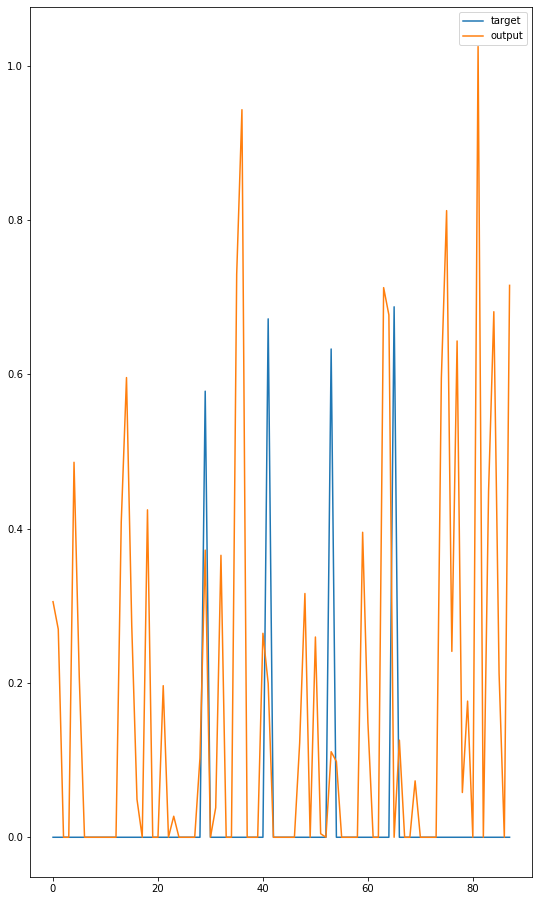

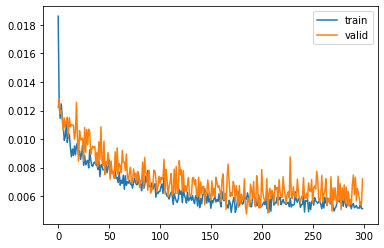

train loss: 0.018609376001894197, valid loss: 0.012206263857606415
train loss: 0.012431211190768213, valid loss: 0.012809578834153781
train loss: 0.01145405069245983, valid loss: 0.011785392362241433


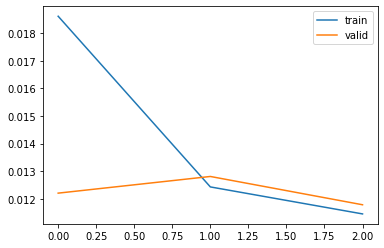

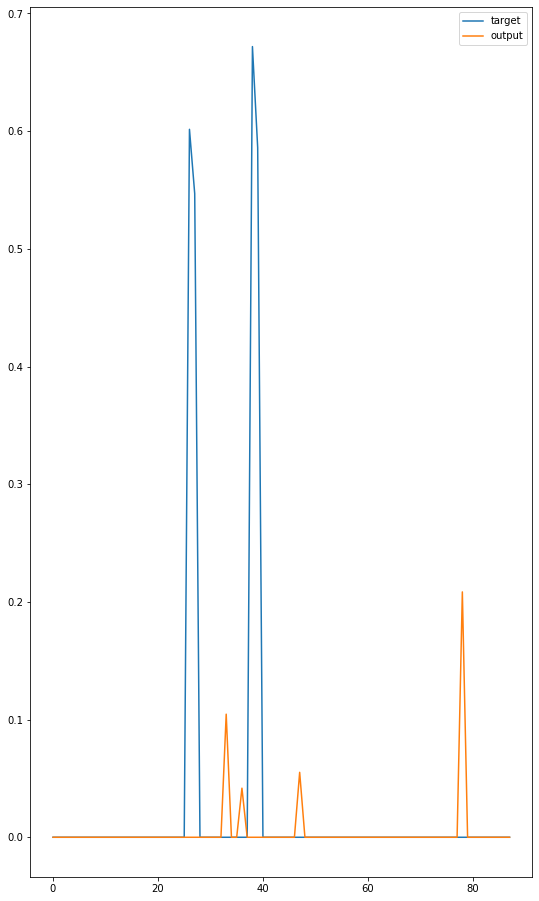

train loss: 0.012464075745300991, valid loss: 0.011990586408875256
train loss: 0.011584347775467088, valid loss: 0.011400956381982732
train loss: 0.01088651423516605, valid loss: 0.010599642356631354


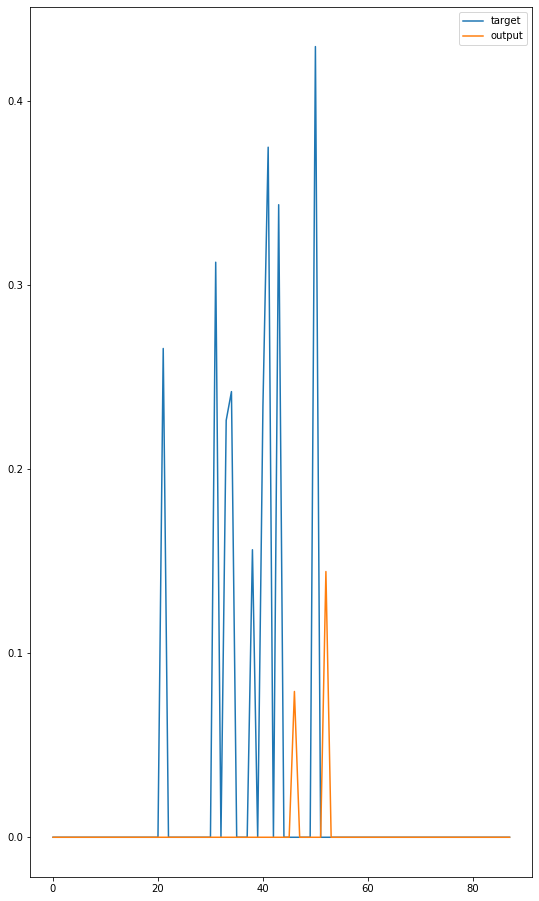

train loss: 0.009916951975602413, valid loss: 0.01147877016740146
train loss: 0.010146504039571526, valid loss: 0.010778712456889241
train loss: 0.011073602465738621, valid loss: 0.011209835942451642


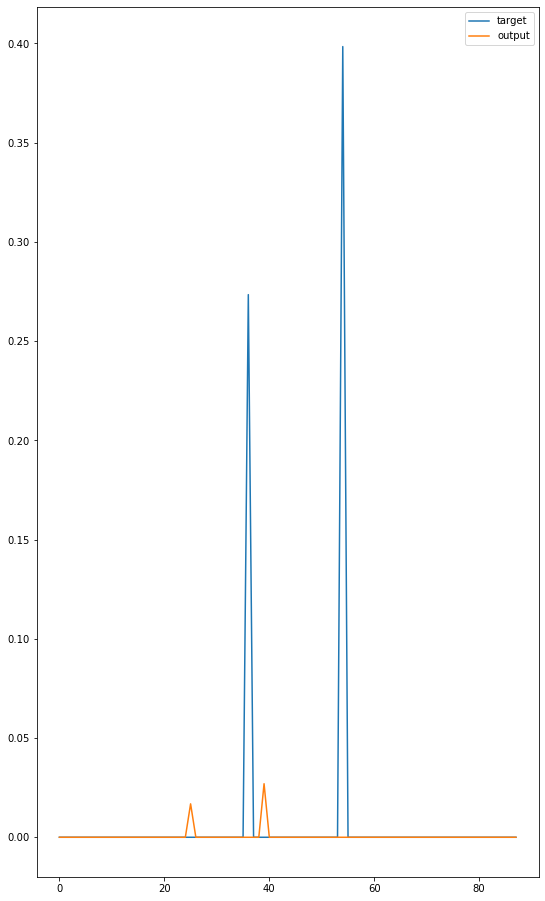

train loss: 0.009760856469570894, valid loss: 0.011526244248602992
train loss: 0.010367873122602284, valid loss: 0.01018356571896611
train loss: 0.010303126706820086, valid loss: 0.011492739118217864


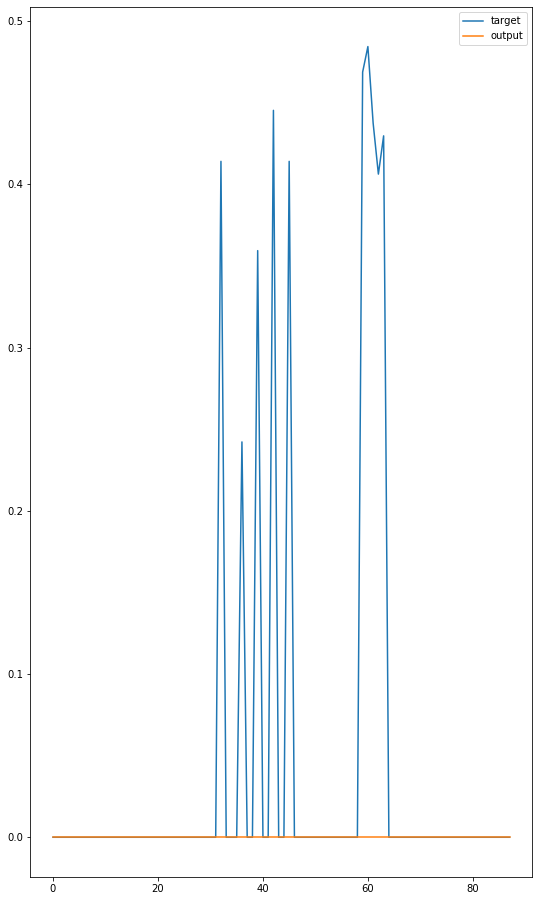

train loss: 0.009407588604959511, valid loss: 0.010873305811503224
train loss: 0.008753996532819469, valid loss: 0.011015618124228214
train loss: 0.009304366888321727, valid loss: 0.010960512167869885


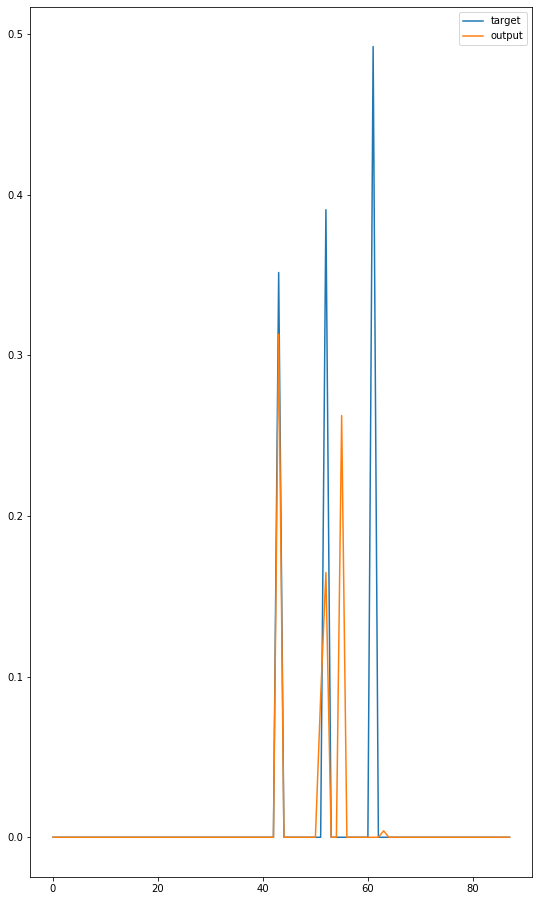

train loss: 0.008848229081535312, valid loss: 0.010975996545890224
train loss: 0.009514103254094441, valid loss: 0.00999019864215472
train loss: 0.008899103709775084, valid loss: 0.01050472783499232


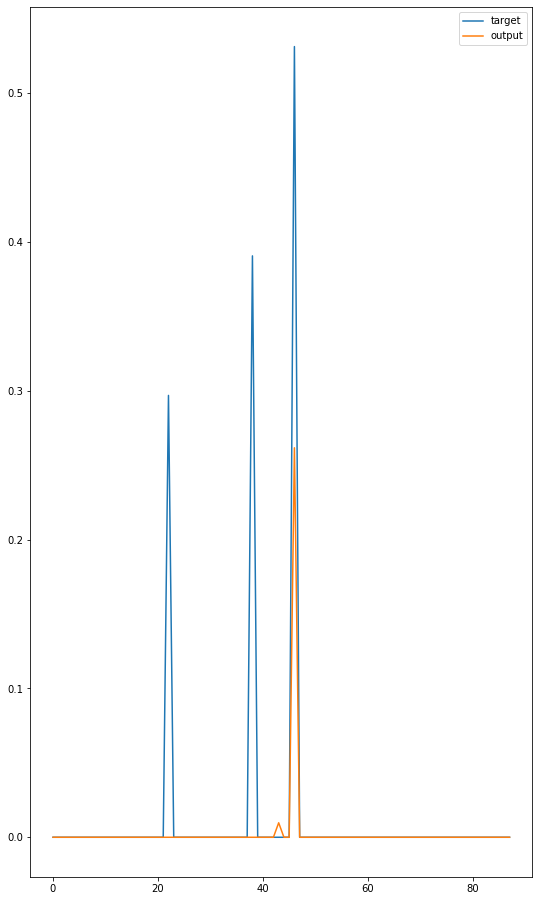

train loss: 0.009543366066537032, valid loss: 0.01256399176945196
train loss: 0.009711672338683194, valid loss: 0.01006067852341683
train loss: 0.008905717687437607, valid loss: 0.008445820910420931


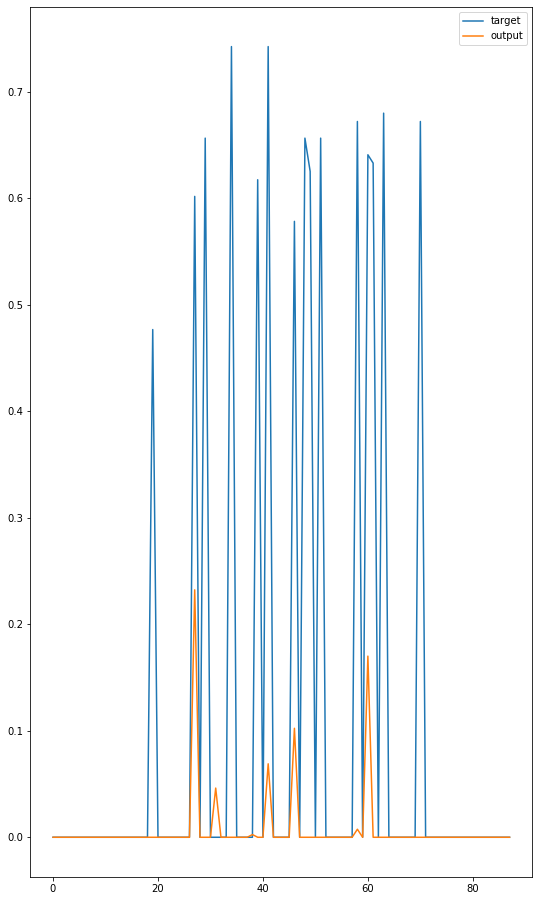

train loss: 0.009167445238209634, valid loss: 0.010590329017733859
train loss: 0.008575553060335186, valid loss: 0.009933563889326336
train loss: 0.008978140438149604, valid loss: 0.0099753582954546


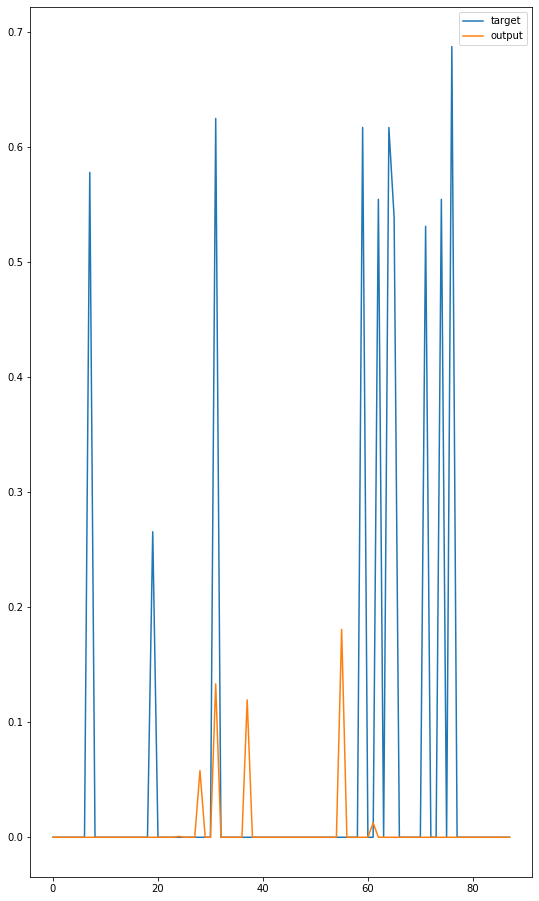

train loss: 0.009561208831842676, valid loss: 0.010069190089321025
train loss: 0.008160696966599709, valid loss: 0.008459857543147056
train loss: 0.00885828664073738, valid loss: 0.010798307570898644


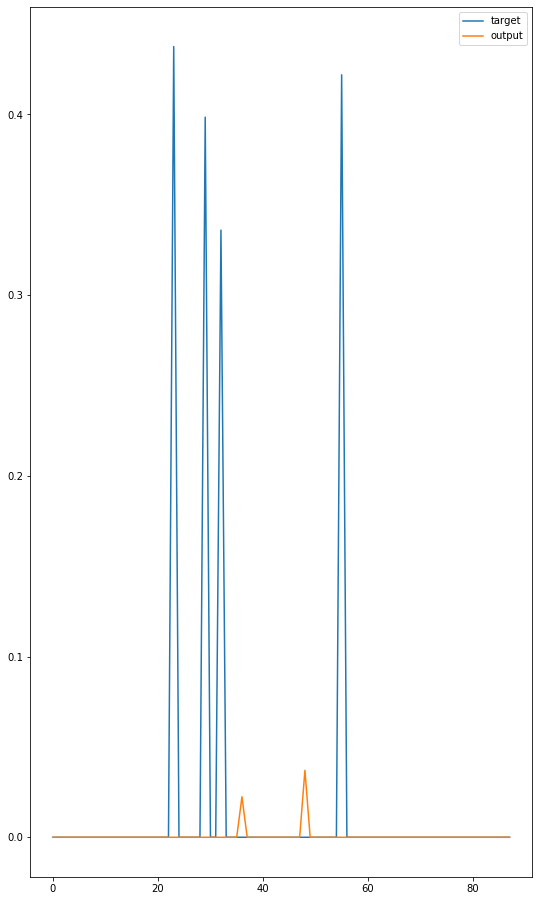

train loss: 0.008192349955326417, valid loss: 0.009074676642629587
train loss: 0.00843217036638966, valid loss: 0.010662438339231728
train loss: 0.008508584059548572, valid loss: 0.009603245061970203


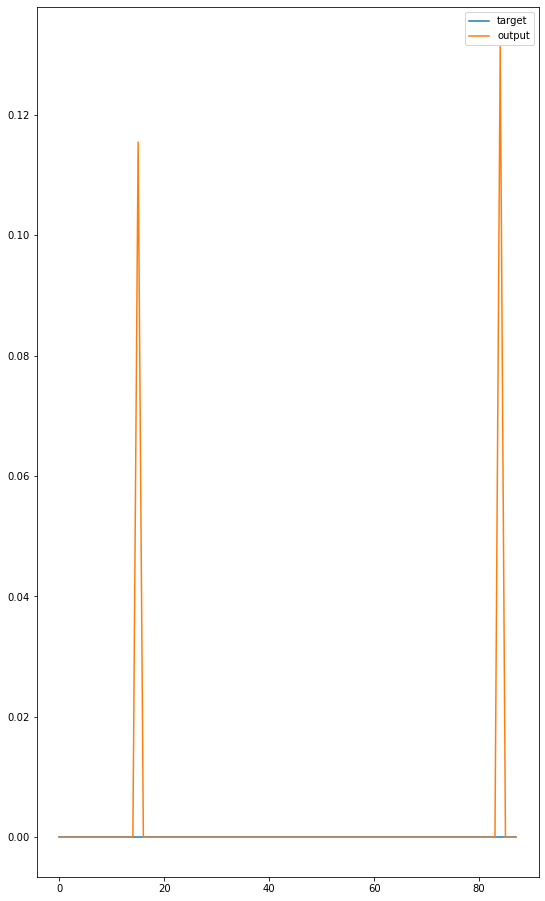

train loss: 0.00797889588148307, valid loss: 0.010689145720032888
train loss: 0.009239846292152026, valid loss: 0.010477044993889666
train loss: 0.008548675753419922, valid loss: 0.008924735857991972


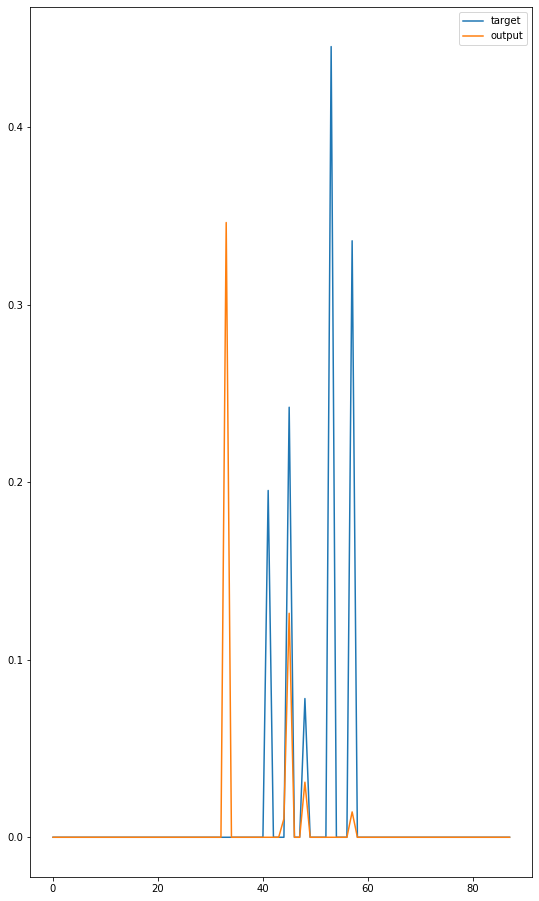

train loss: 0.00814273268545795, valid loss: 0.009265141335324707
train loss: 0.008090421931696273, valid loss: 0.00950560787535995
train loss: 0.008338451010140234, valid loss: 0.009387792523288838


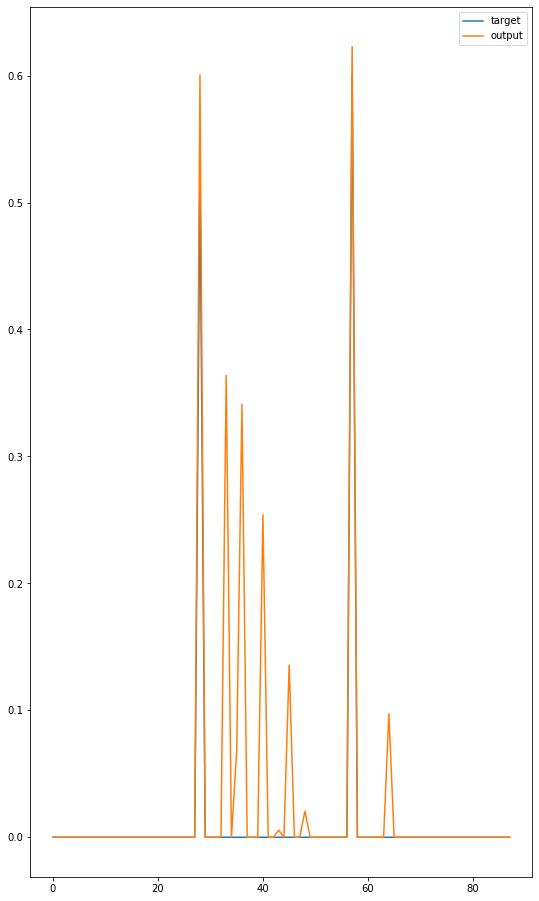

train loss: 0.008393988502864665, valid loss: 0.00948003881445555
train loss: 0.008184375110839573, valid loss: 0.008239870325218295
train loss: 0.008269694009273548, valid loss: 0.009061172665488497


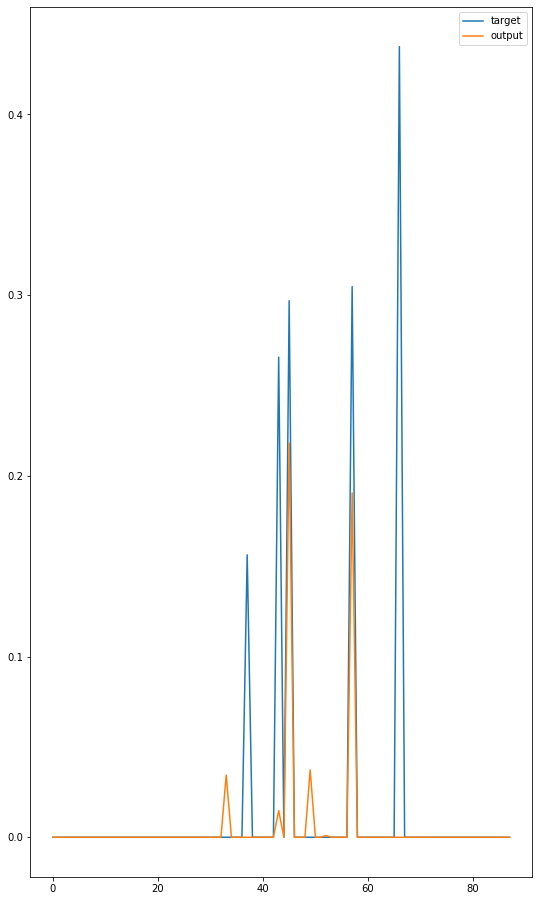

train loss: 0.007862690844895126, valid loss: 0.008049447193881062
train loss: 0.008471686166719856, valid loss: 0.00980732704852229
train loss: 0.007365816915799454, valid loss: 0.008550999712233788


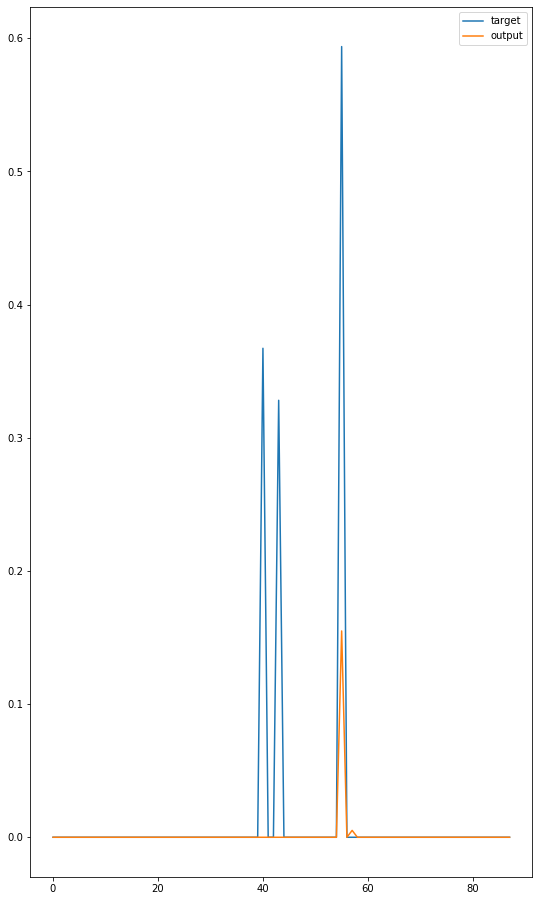

train loss: 0.008163742399034656, valid loss: 0.010857128825421645
train loss: 0.008224186928133332, valid loss: 0.008514298474259465
train loss: 0.00784147540694886, valid loss: 0.008126823414360808


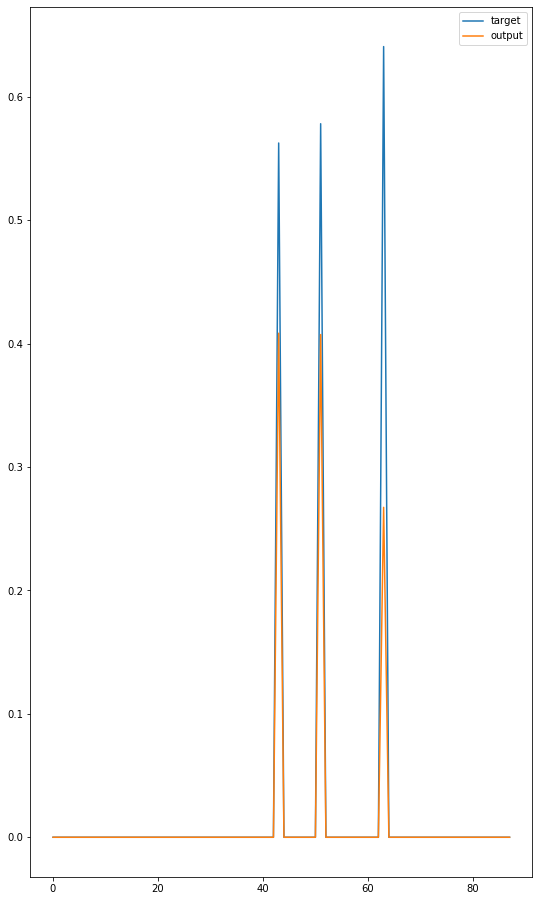

train loss: 0.00784167799680868, valid loss: 0.009857191164568763
train loss: 0.007860132493078709, valid loss: 0.007519966435279244
train loss: 0.008371167475679698, valid loss: 0.008403292099866911


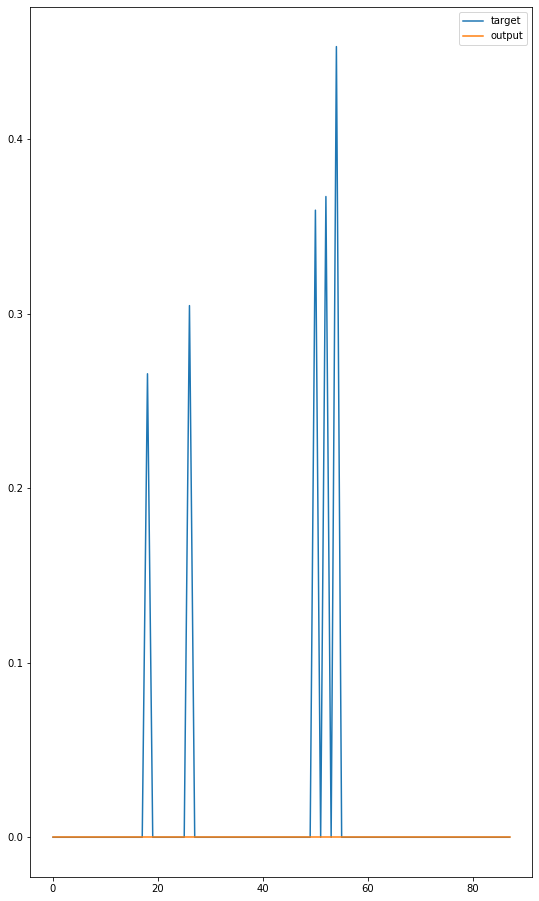

train loss: 0.0076354838674888015, valid loss: 0.008265060581545407
train loss: 0.00801684171457505, valid loss: 0.0090559060102172
train loss: 0.008554328354858906, valid loss: 0.0083701950889603


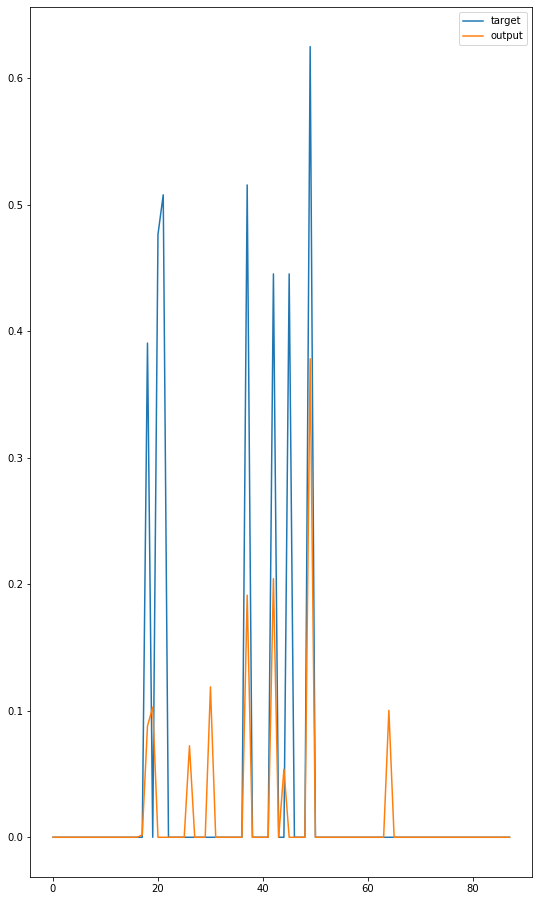

train loss: 0.008256156219465433, valid loss: 0.007186265375082181
train loss: 0.0077693133188463815, valid loss: 0.008462284169394835
train loss: 0.007736788048609116, valid loss: 0.007570037043818804


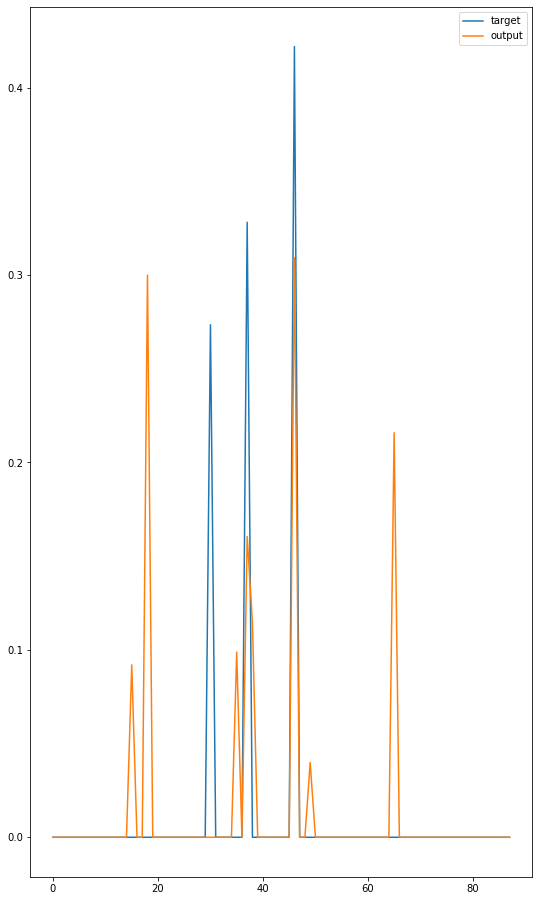

train loss: 0.007667900606006315, valid loss: 0.007744027127590135
train loss: 0.007391615833860831, valid loss: 0.007246030664297743
train loss: 0.007933395455600085, valid loss: 0.009109496661226884


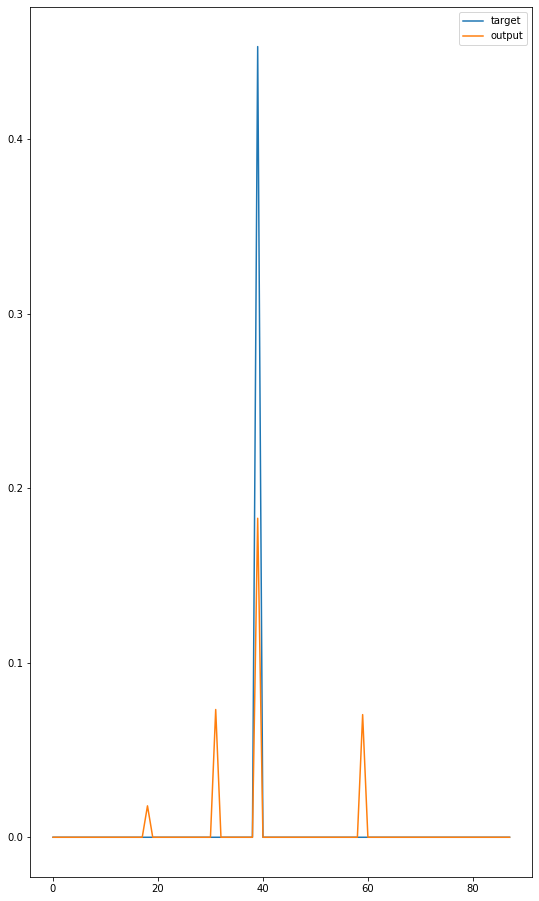

train loss: 0.007232361555830619, valid loss: 0.007737066927496518
train loss: 0.007294377710269851, valid loss: 0.009392685639872172
train loss: 0.006956861775464195, valid loss: 0.007520973073127114


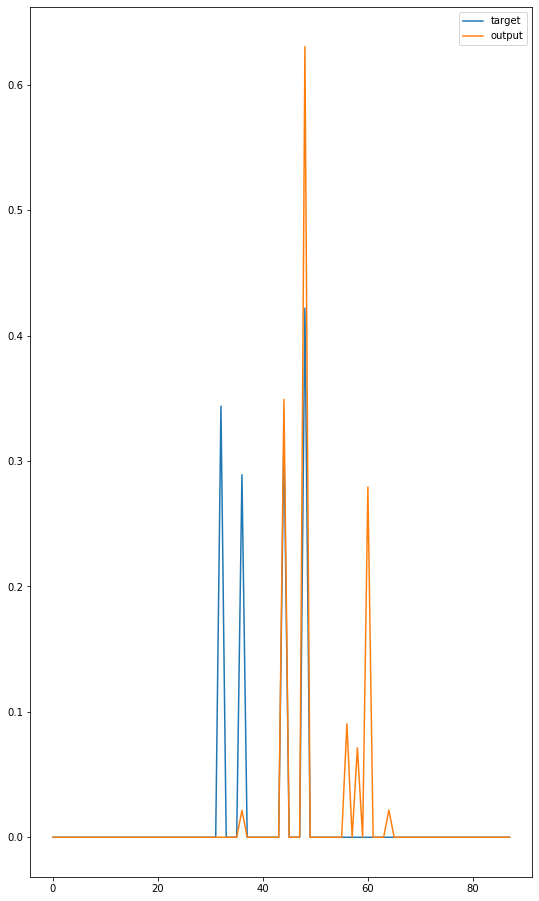

train loss: 0.00769529312470423, valid loss: 0.00828434150909709
train loss: 0.006770692146644344, valid loss: 0.008131055022093736
train loss: 0.00711599543416507, valid loss: 0.007639449716449898


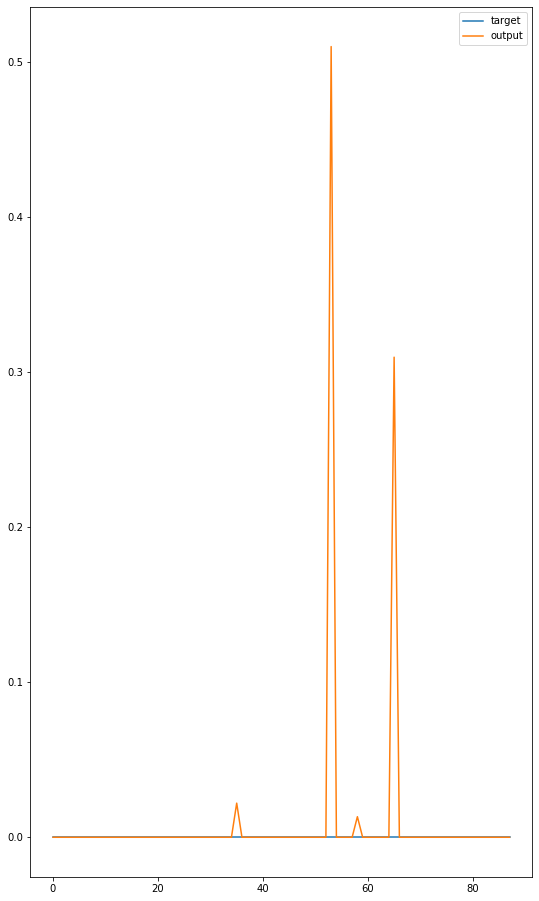

train loss: 0.00689401621952061, valid loss: 0.009202100632485942
train loss: 0.007474705409345643, valid loss: 0.008380345843523462
train loss: 0.006481872393888918, valid loss: 0.008382845548129528


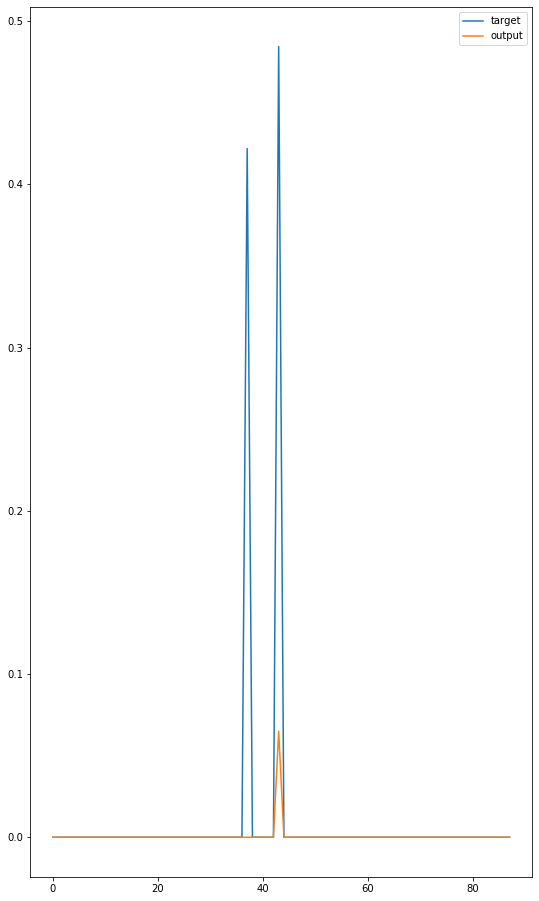

train loss: 0.00742770893886581, valid loss: 0.007790543286948003
train loss: 0.00675667713779225, valid loss: 0.00895028529149071
train loss: 0.007010438215100668, valid loss: 0.0074143706968872345


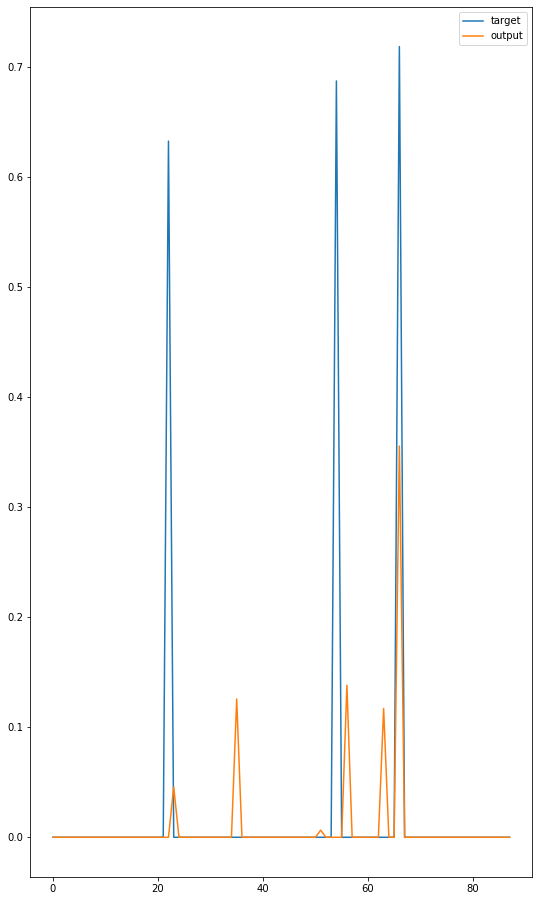

train loss: 0.0069099687089899855, valid loss: 0.0071125399434469015
train loss: 0.007100525703803401, valid loss: 0.0075967657579996874
train loss: 0.0068343406005666775, valid loss: 0.008018870585571939


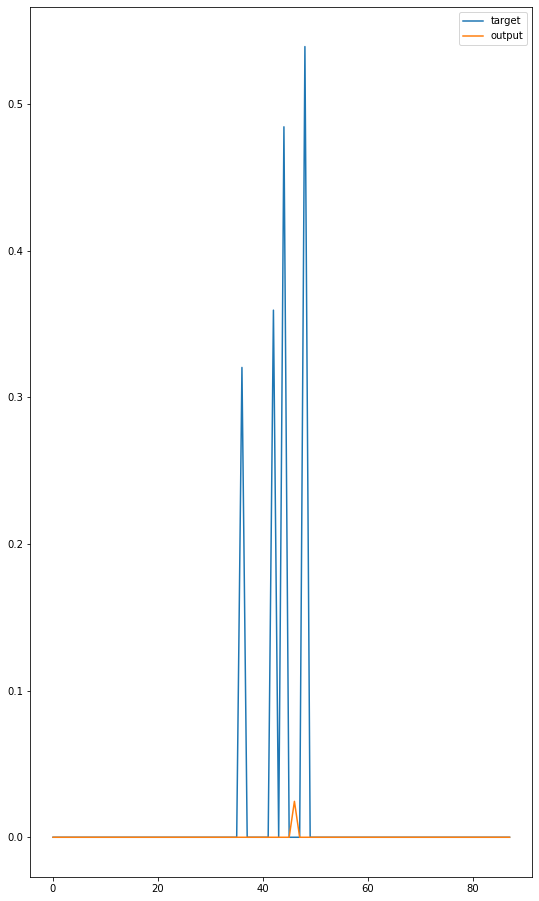

train loss: 0.006897416655583499, valid loss: 0.006917587181152863
train loss: 0.006561124736495385, valid loss: 0.006970444876944351
train loss: 0.006915311691368642, valid loss: 0.00790504625537128


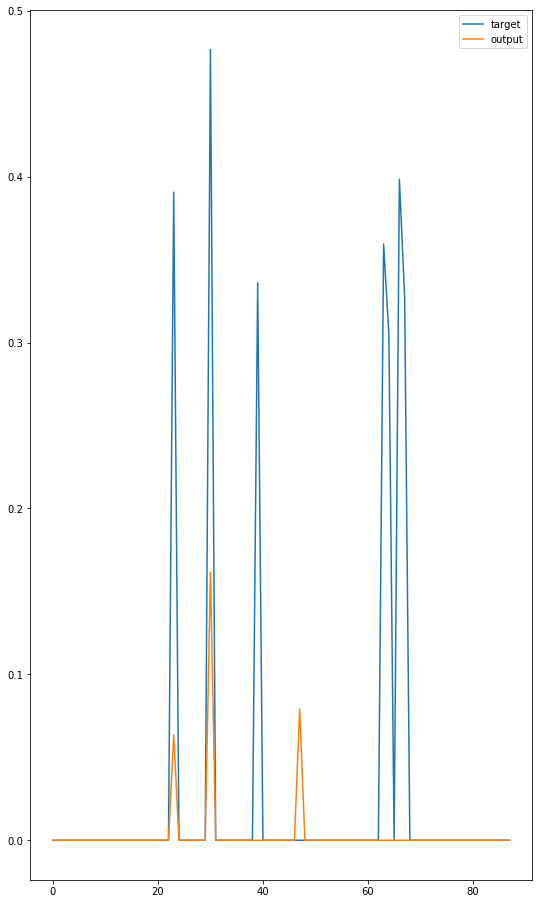

train loss: 0.00726756380400925, valid loss: 0.007391022113543526
train loss: 0.00695402786749302, valid loss: 0.007597594217301529
train loss: 0.00679082776828904, valid loss: 0.006928699012741307


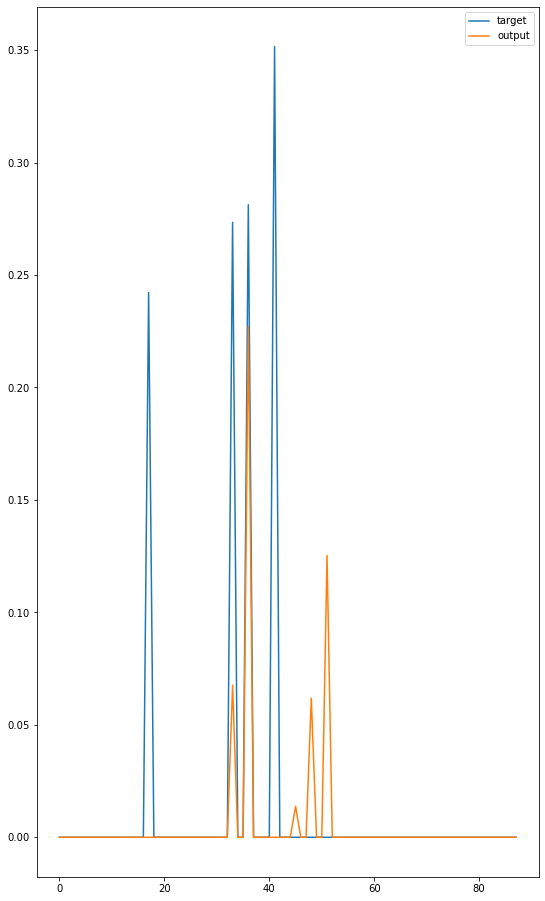

train loss: 0.00683309483803182, valid loss: 0.007732019611747466
train loss: 0.007483072409180002, valid loss: 0.007567988208138219
train loss: 0.0067649635760479165, valid loss: 0.006601556108515954


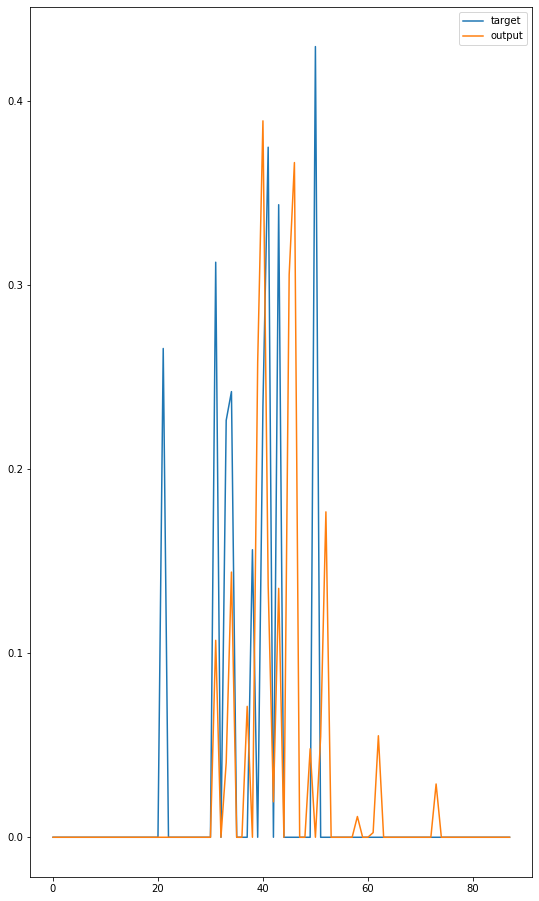

train loss: 0.006803835079587439, valid loss: 0.00710169338647311
train loss: 0.006373624542562691, valid loss: 0.007085319142788649
train loss: 0.007422653763450543, valid loss: 0.0083886128719722


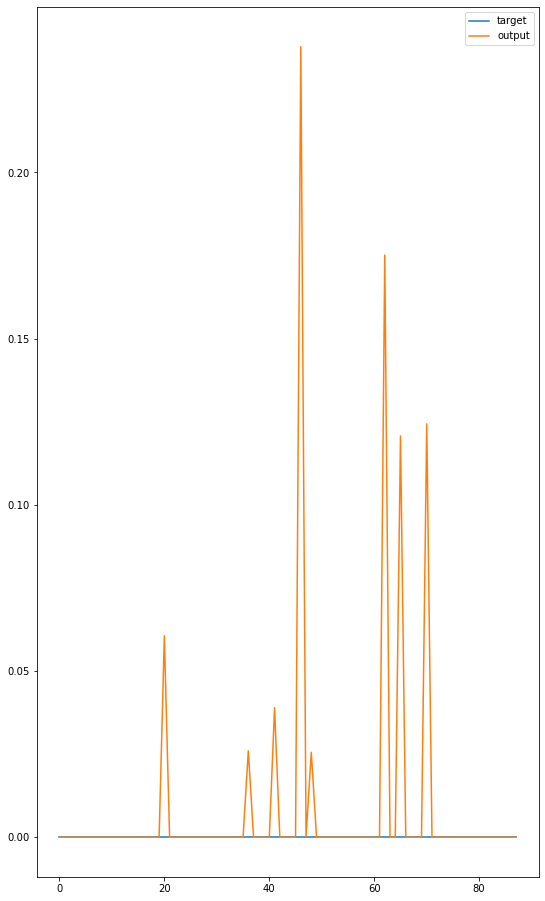

train loss: 0.00654867274369, valid loss: 0.00654648324022087
train loss: 0.00674725919156814, valid loss: 0.008709589611286315
train loss: 0.007409146227482184, valid loss: 0.0076517968299302545


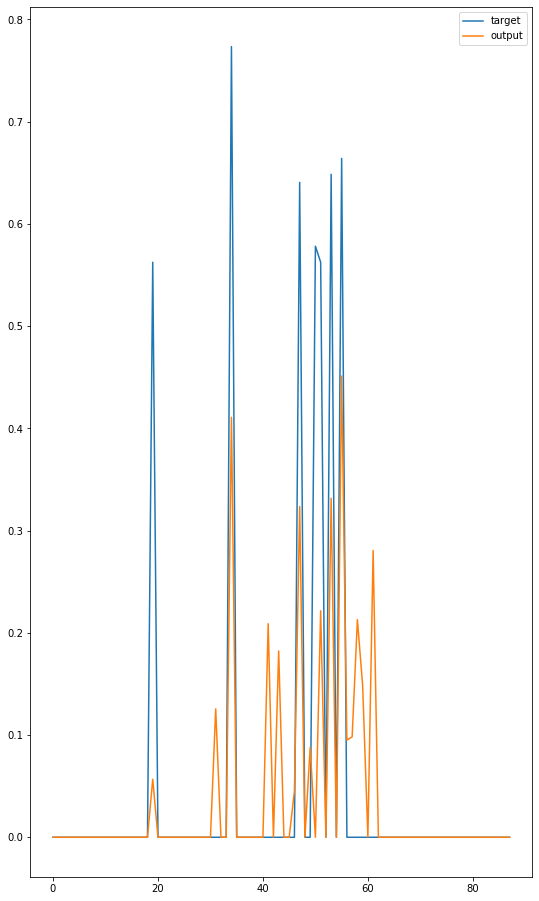

train loss: 0.006981594729559304, valid loss: 0.0075398471693847785
train loss: 0.007790504854659889, valid loss: 0.006407499953094765
train loss: 0.0066727711394794775, valid loss: 0.007812205493171638


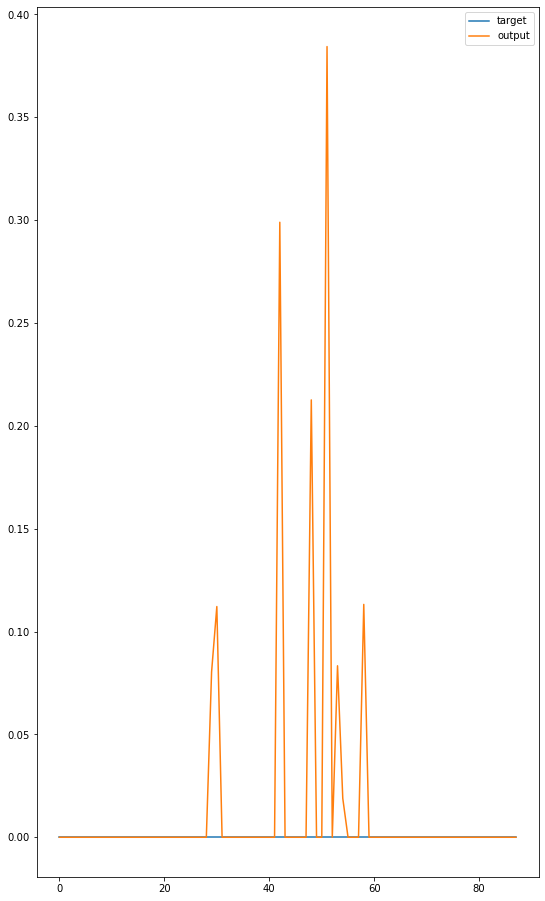

train loss: 0.006679502793448481, valid loss: 0.007187192115027492
train loss: 0.006601656638042322, valid loss: 0.006210380481886808
train loss: 0.006919045359218301, valid loss: 0.006453310587730641


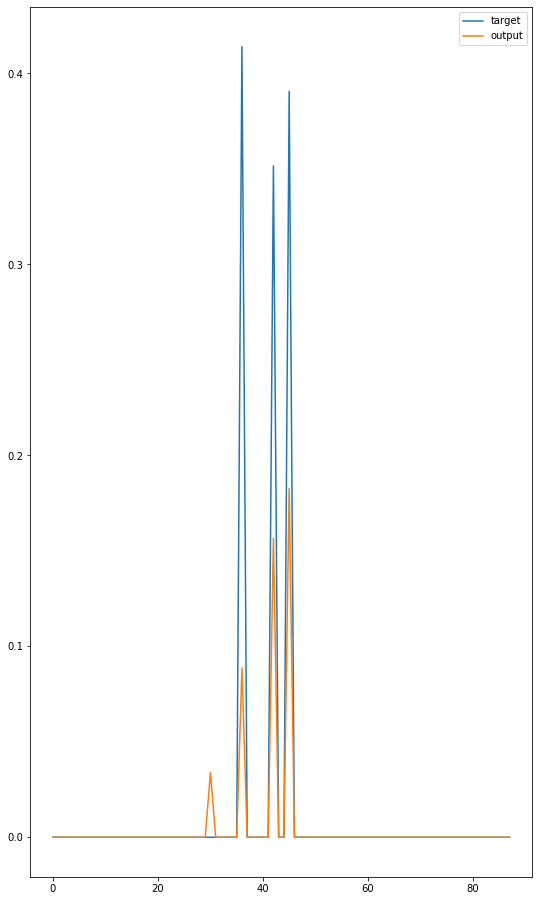

train loss: 0.006486012766825331, valid loss: 0.006722341713747967
train loss: 0.006736408750456975, valid loss: 0.007821248261101334
train loss: 0.006865909634262463, valid loss: 0.00777581108681788


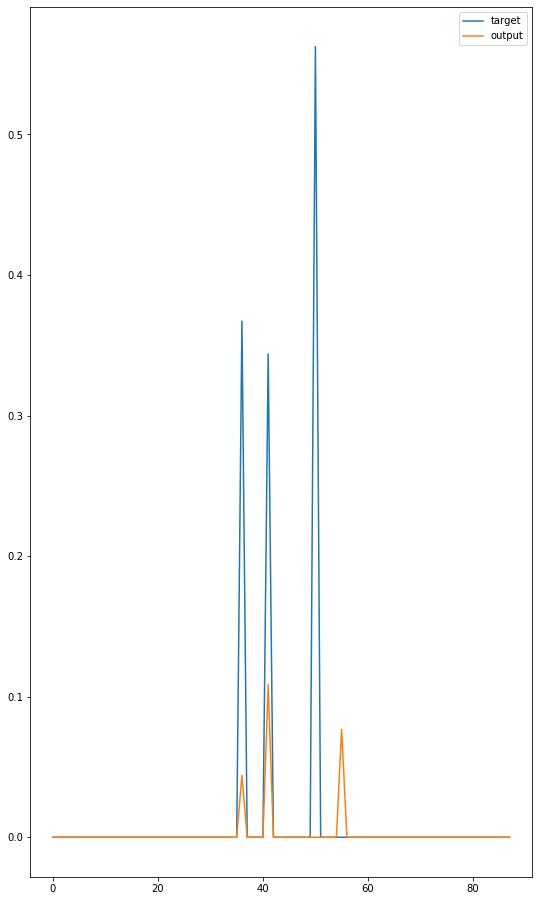

train loss: 0.005920949733650712, valid loss: 0.007196586896778546
train loss: 0.006443164574643858, valid loss: 0.00630106313902641
train loss: 0.006172427246085951, valid loss: 0.006690266333241886


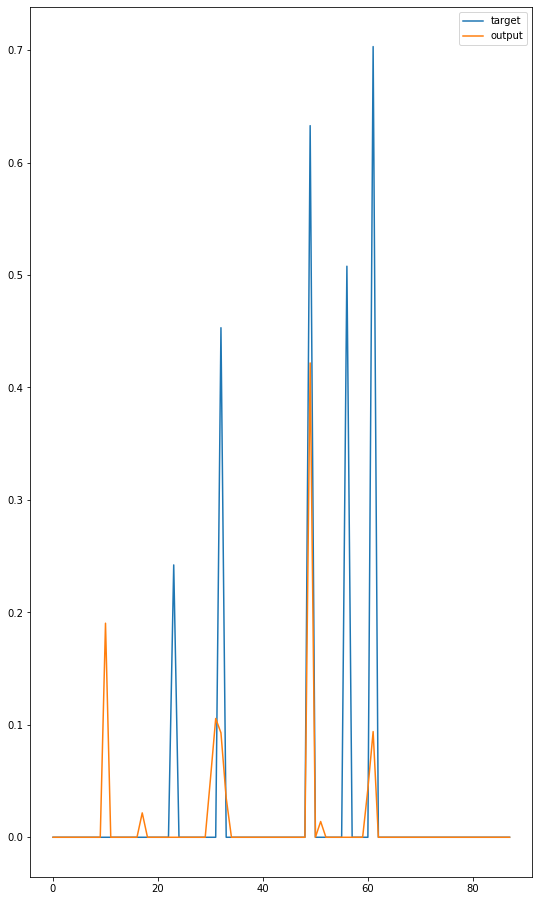

train loss: 0.006326508224141027, valid loss: 0.007387869817283109
train loss: 0.006330602552097673, valid loss: 0.006891553507787045
train loss: 0.0066760166844126775, valid loss: 0.007320540978912717


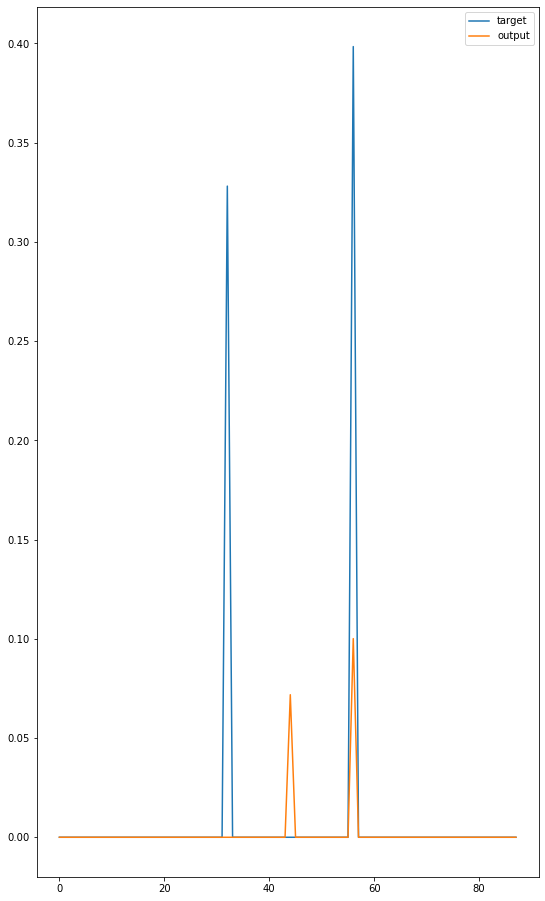

train loss: 0.00685516972133942, valid loss: 0.007154160849401884
train loss: 0.006182257937937627, valid loss: 0.007350176677247074
train loss: 0.0075596825580904695, valid loss: 0.008578659775101137


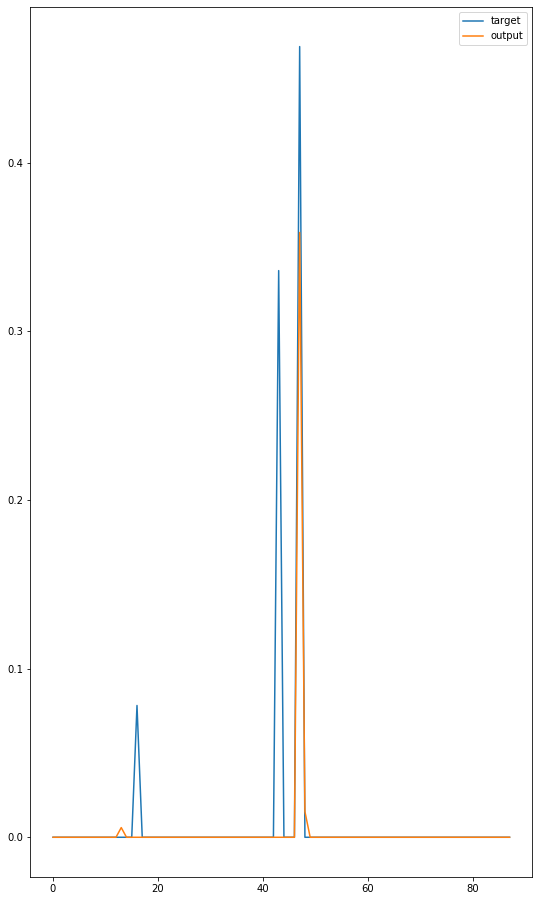

train loss: 0.006394746232447084, valid loss: 0.0061379634931892435
train loss: 0.006170057823280934, valid loss: 0.007869426100123152
train loss: 0.005992459345426166, valid loss: 0.007159768303455872


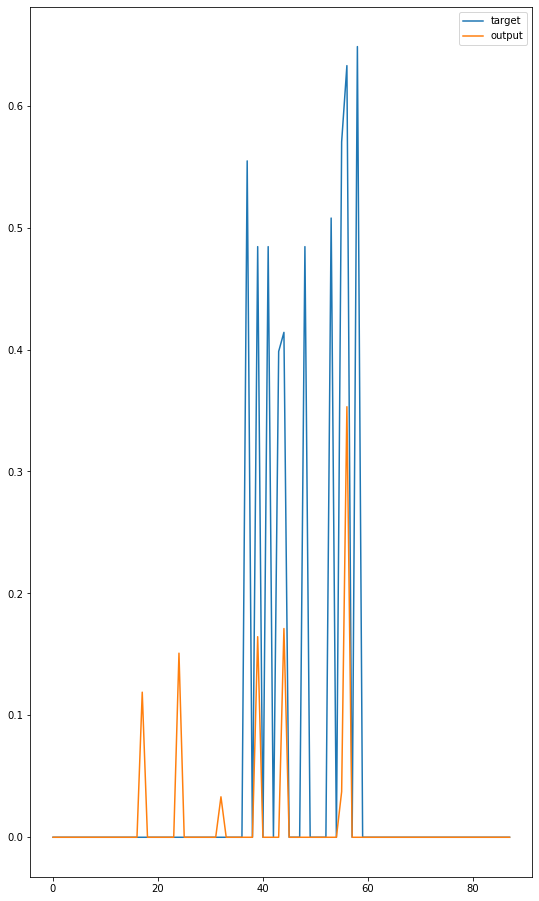

train loss: 0.005970259636605733, valid loss: 0.005972854492785496
train loss: 0.005791518200737224, valid loss: 0.006698394720834271
train loss: 0.0060838353482867095, valid loss: 0.006974682686241152


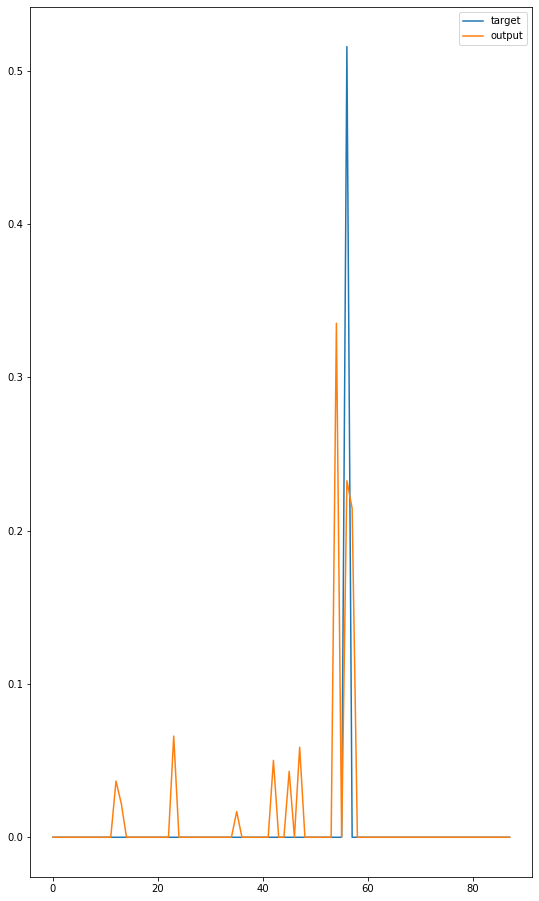

train loss: 0.006290879168016749, valid loss: 0.007583547514106069
train loss: 0.006062287035415593, valid loss: 0.006077749580667119
train loss: 0.005415204089900879, valid loss: 0.006235540270039411


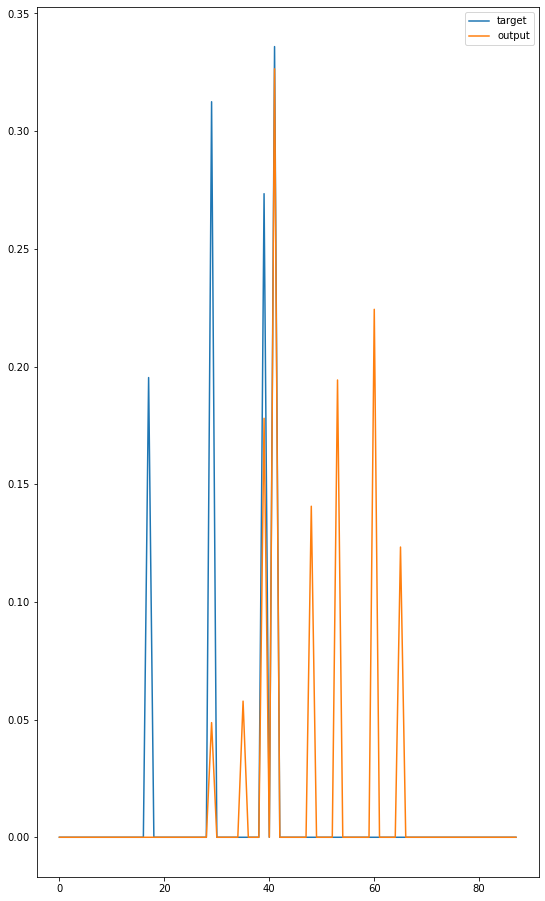

train loss: 0.006178136162076877, valid loss: 0.00789492328381427
train loss: 0.005897031411545995, valid loss: 0.006186426177655704
train loss: 0.005664097713132467, valid loss: 0.008071910476782055


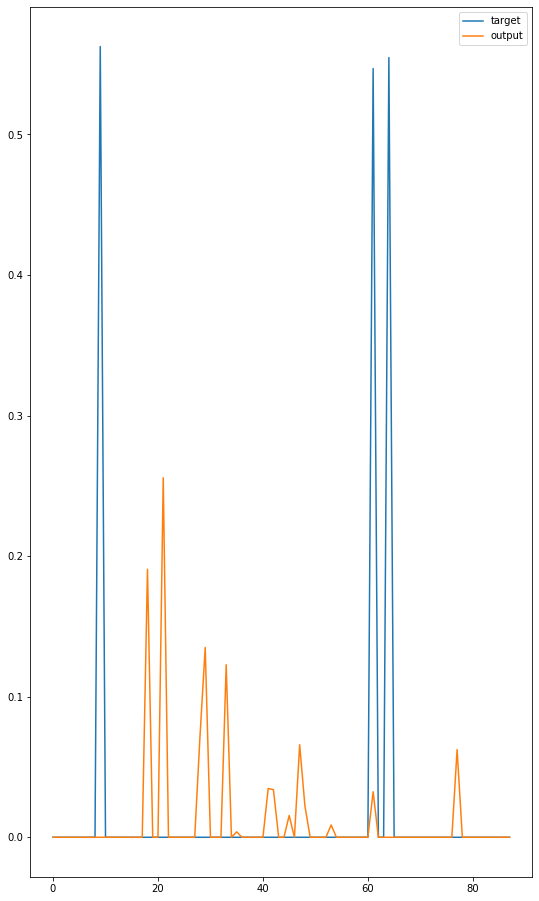

train loss: 0.005555452462329277, valid loss: 0.0061733444290949365
train loss: 0.005815084475292781, valid loss: 0.006364057841493148
train loss: 0.006455552719629187, valid loss: 0.008485469653784671


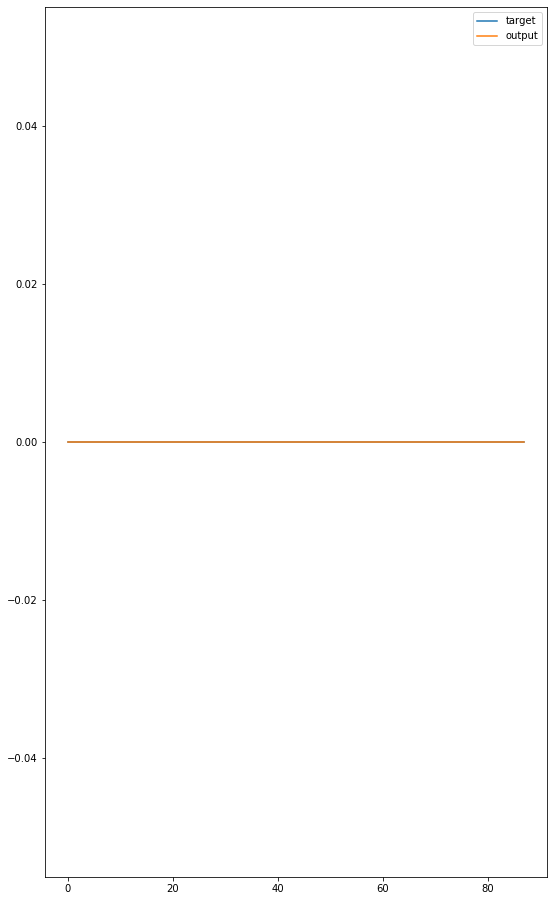

train loss: 0.006135766216005398, valid loss: 0.007496102882775469
train loss: 0.006359634146303217, valid loss: 0.007842752921490748
train loss: 0.005533256899852688, valid loss: 0.006351350510719223


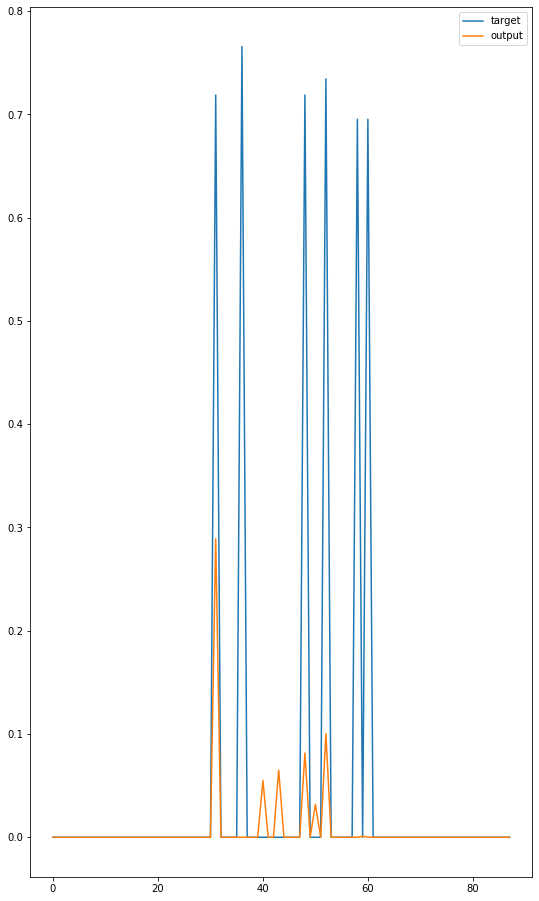

train loss: 0.00655413431193784, valid loss: 0.007780553816565287
train loss: 0.0060653048937391735, valid loss: 0.006306075116741323
train loss: 0.005864101224883555, valid loss: 0.006725428007960876


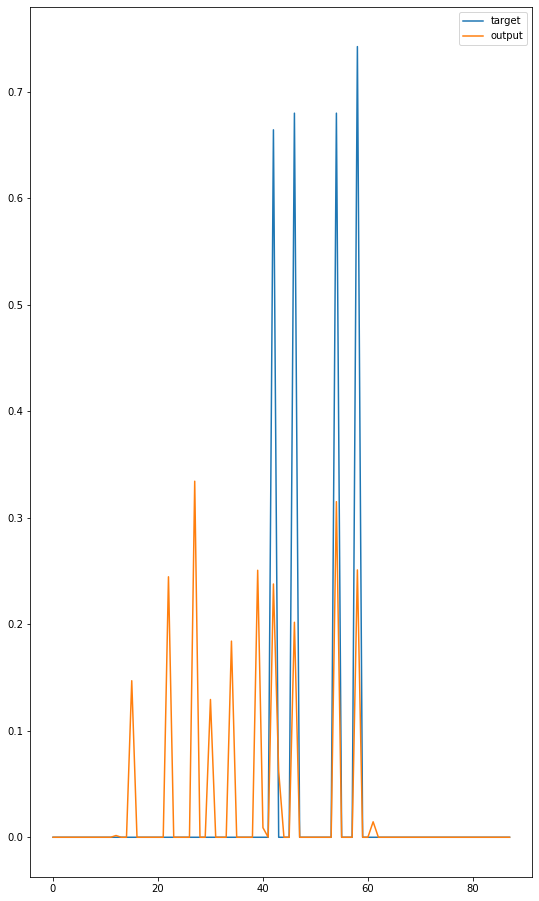

train loss: 0.005519500702932895, valid loss: 0.006286278632512995
train loss: 0.006278265270874531, valid loss: 0.006823702989511679
train loss: 0.005672862384442205, valid loss: 0.007288007953456629


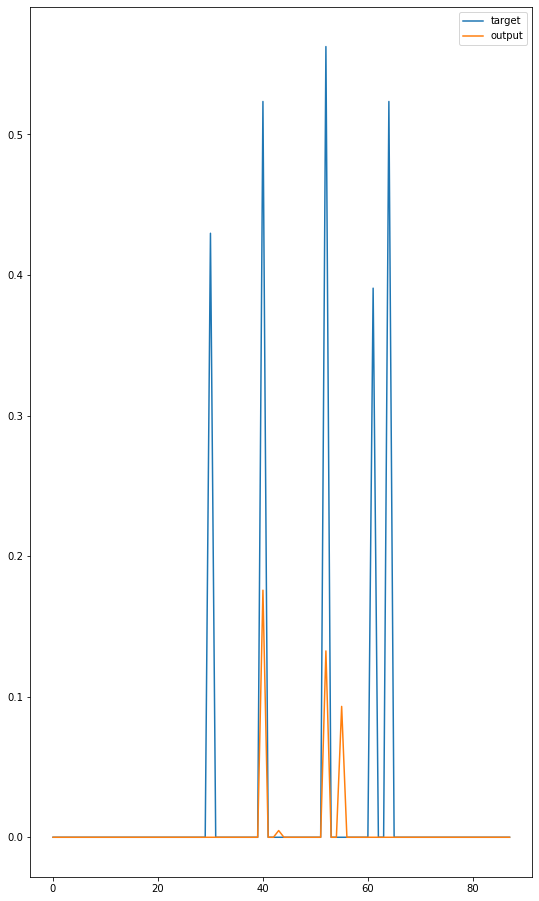

train loss: 0.005783435414223192, valid loss: 0.00611178972540754
train loss: 0.005987270765668042, valid loss: 0.006015169603976412
train loss: 0.005707344127314113, valid loss: 0.006154151559398274


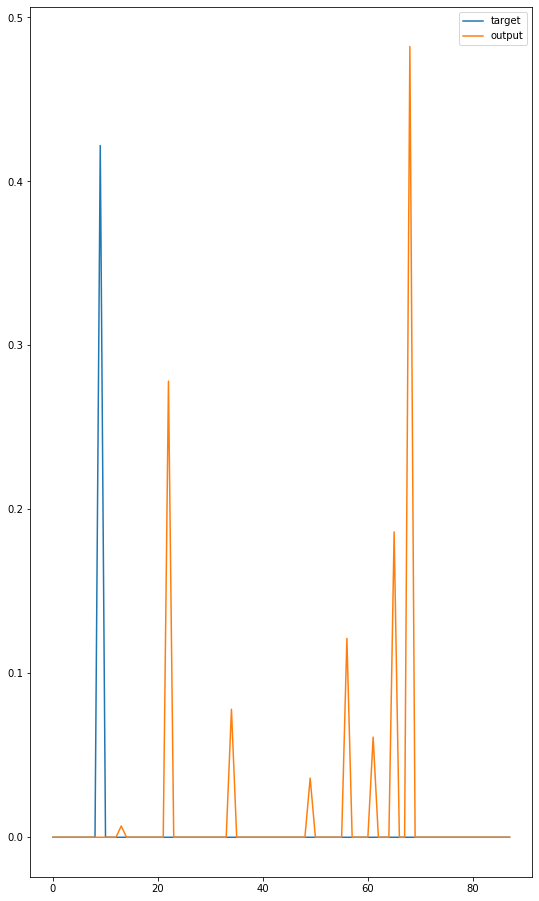

train loss: 0.006030060099568392, valid loss: 0.007277245137179009
train loss: 0.005687337706004766, valid loss: 0.007303599729507326
train loss: 0.005469631674595038, valid loss: 0.006788242773683829


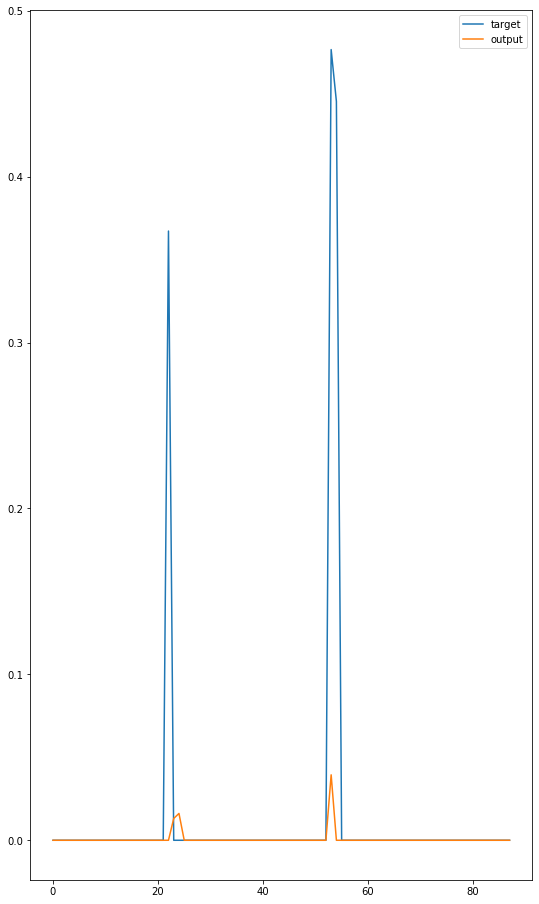

train loss: 0.006023866140771065, valid loss: 0.007147693553956869
train loss: 0.0059793664286104595, valid loss: 0.0060353365761584765
train loss: 0.005306607784668558, valid loss: 0.005933104030718313


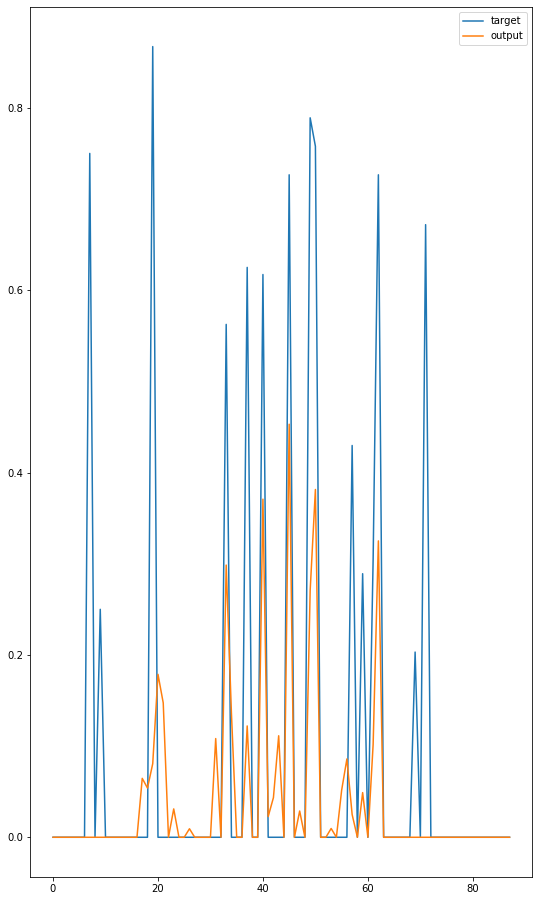

train loss: 0.006668879745188648, valid loss: 0.00731206200494666
train loss: 0.005187591427945854, valid loss: 0.005790505632235904
train loss: 0.00582937825423291, valid loss: 0.006995066778438392


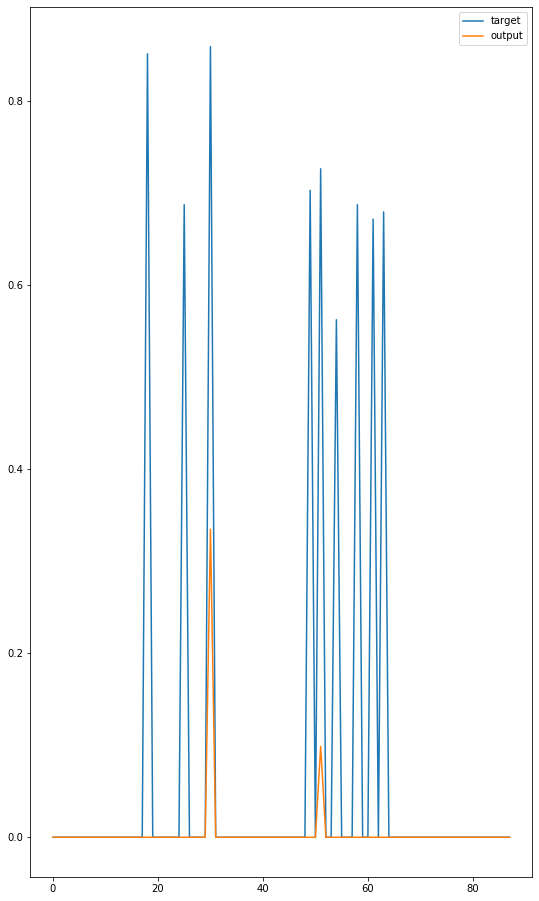

train loss: 0.0054571668684882954, valid loss: 0.006160317576342375
train loss: 0.006115998611480833, valid loss: 0.006683133799304193
train loss: 0.0061200689818170445, valid loss: 0.006664591932791137


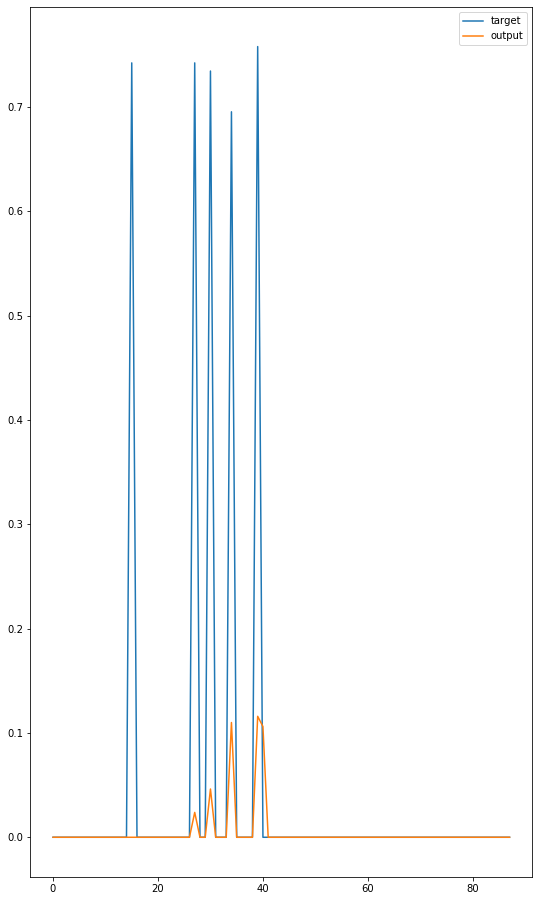

train loss: 0.006510633384486852, valid loss: 0.005391525796605883
train loss: 0.005982959118593379, valid loss: 0.006257031400139643
train loss: 0.005513946138426801, valid loss: 0.006175701436804276


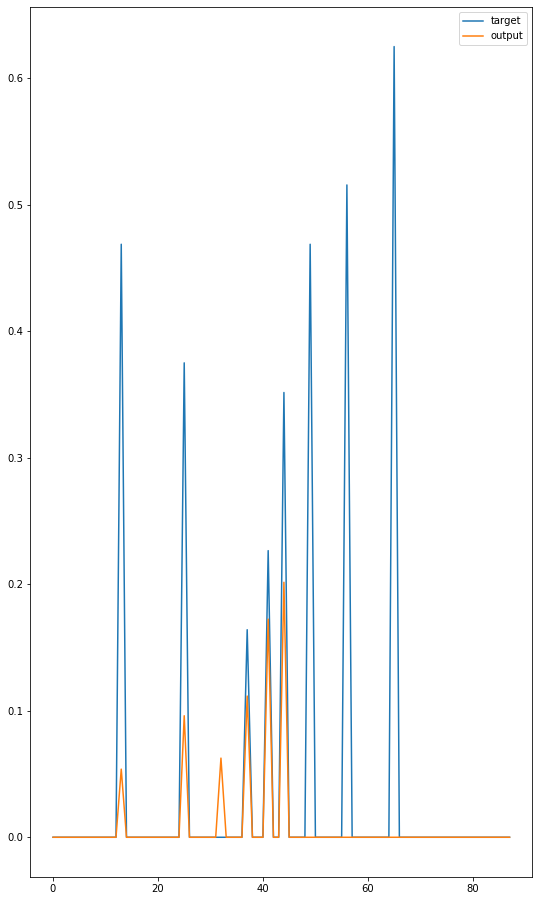

train loss: 0.0061938252722165575, valid loss: 0.007131144474042911
train loss: 0.005597232355710084, valid loss: 0.006414567364083829
train loss: 0.005839852963260888, valid loss: 0.005996669098630408


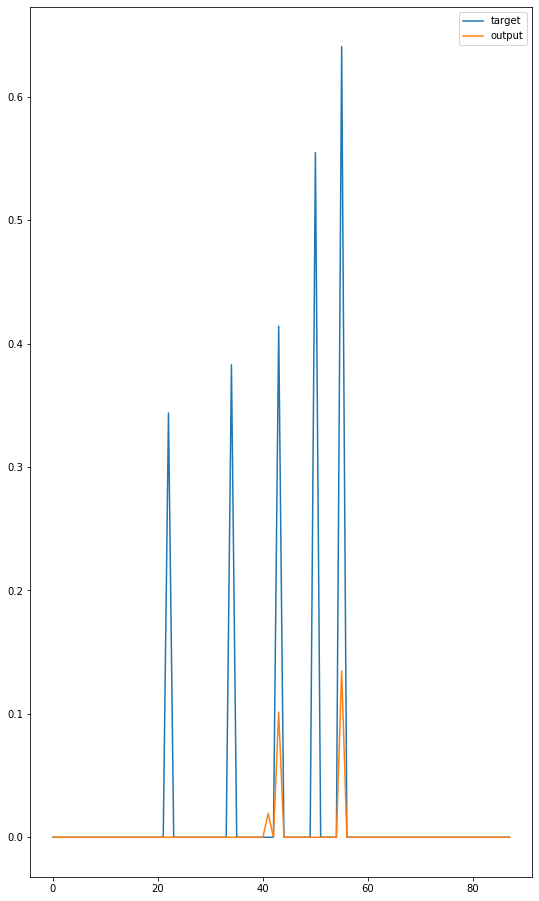

train loss: 0.005150926138370115, valid loss: 0.005715828240962229
train loss: 0.005704718989006757, valid loss: 0.00706569625012507
train loss: 0.005533024010457377, valid loss: 0.006003237795084715


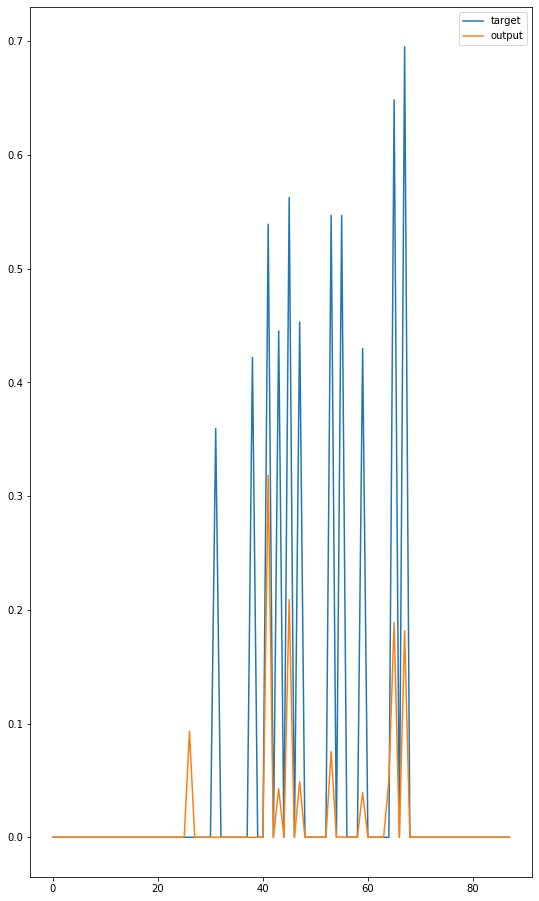

train loss: 0.005819459050832856, valid loss: 0.006550344007490116
train loss: 0.005928857145378384, valid loss: 0.005946273663055117
train loss: 0.005584296600666837, valid loss: 0.007316945447090352


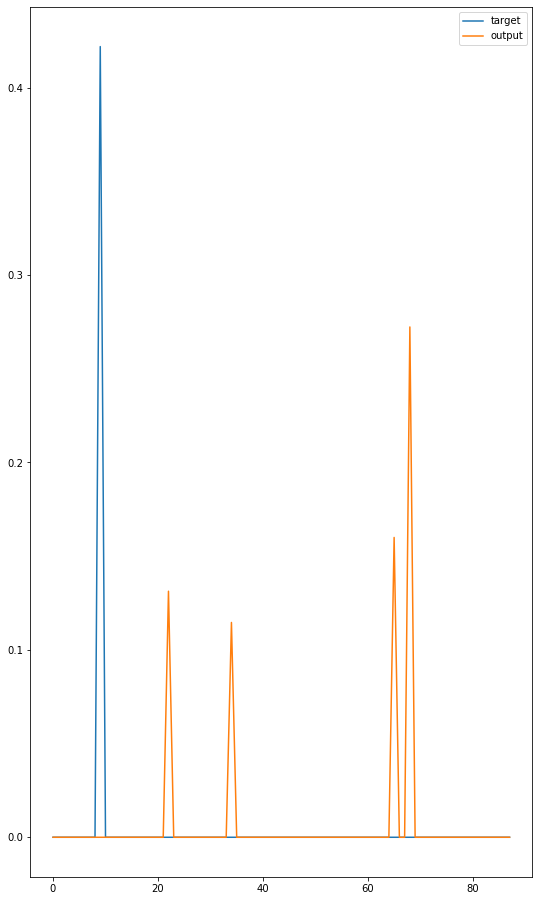

train loss: 0.005754646541611683, valid loss: 0.0069417812269633615
train loss: 0.0056400588630898816, valid loss: 0.006621054465073013
train loss: 0.006159500119920437, valid loss: 0.006713211619094989


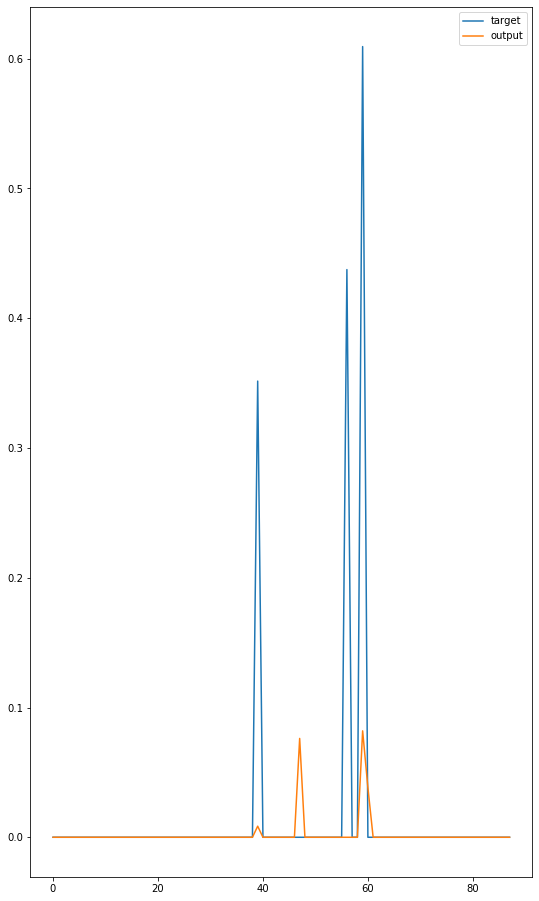

train loss: 0.005628841271445538, valid loss: 0.006349548040323447
train loss: 0.005244498266229214, valid loss: 0.005626917681787337
train loss: 0.006321216071738261, valid loss: 0.007191962854083732


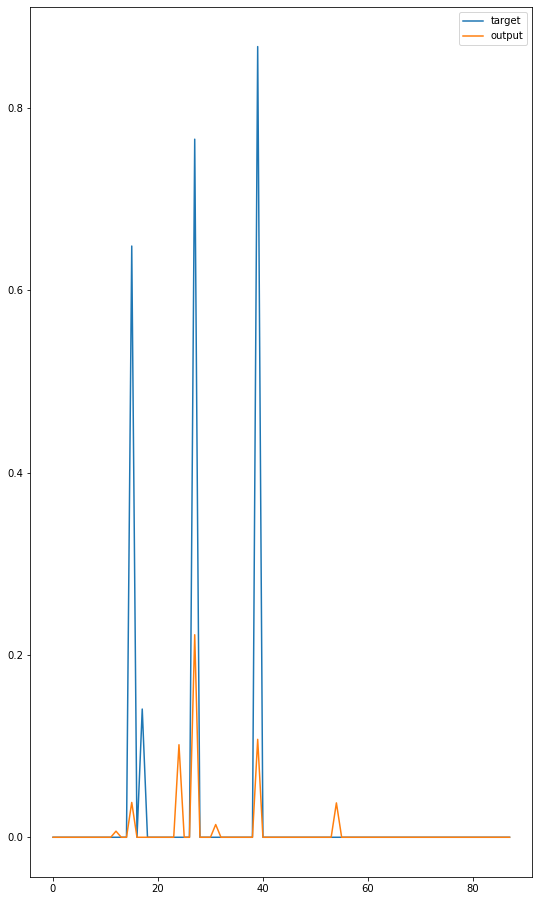

train loss: 0.005798694466580158, valid loss: 0.007555812736537969
train loss: 0.005686020241423606, valid loss: 0.005743238517892695
train loss: 0.00604456475996804, valid loss: 0.006185670439850226


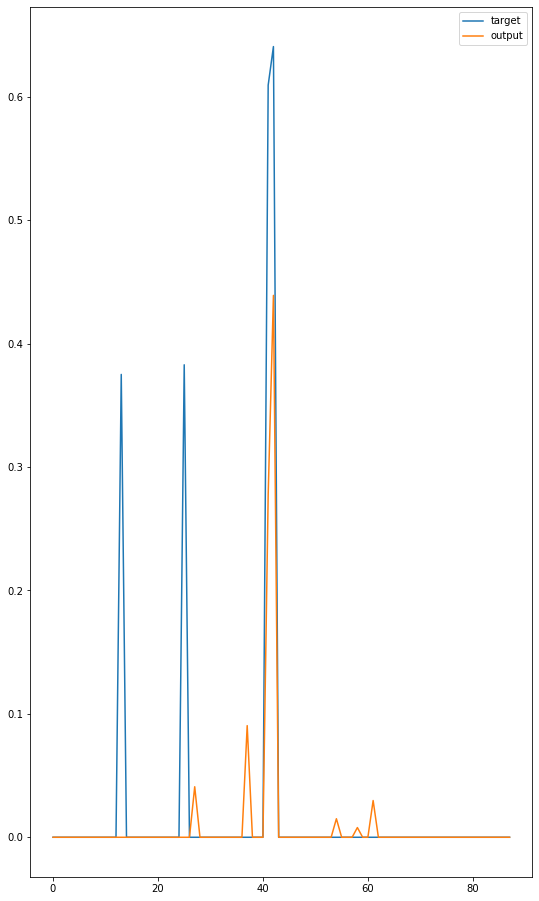

train loss: 0.005481617233637616, valid loss: 0.005080520480035621
train loss: 0.005348842671558818, valid loss: 0.007400010603645416
train loss: 0.0051598741866595976, valid loss: 0.008249553512329253


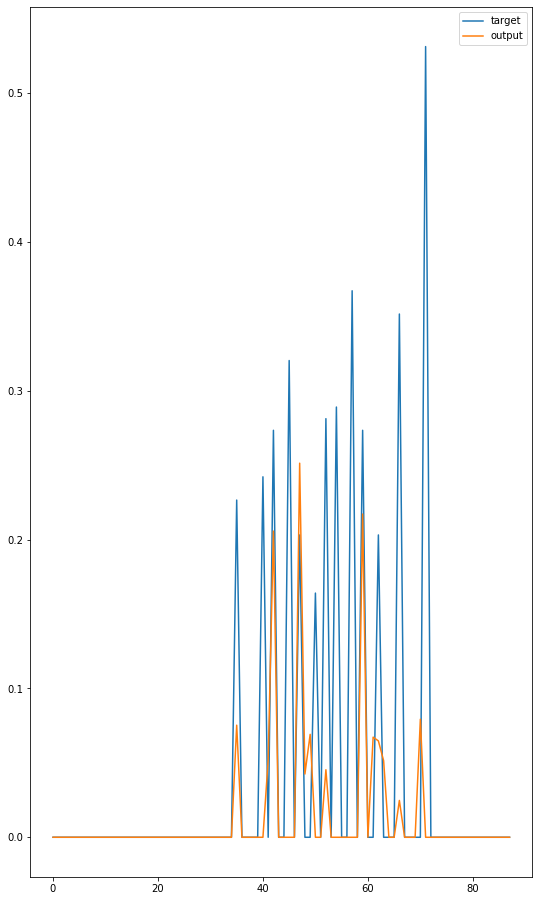

train loss: 0.005711946473239321, valid loss: 0.006917558719238667
train loss: 0.005495630305860992, valid loss: 0.005984722253666303
train loss: 0.004855981427375401, valid loss: 0.006246757310614965


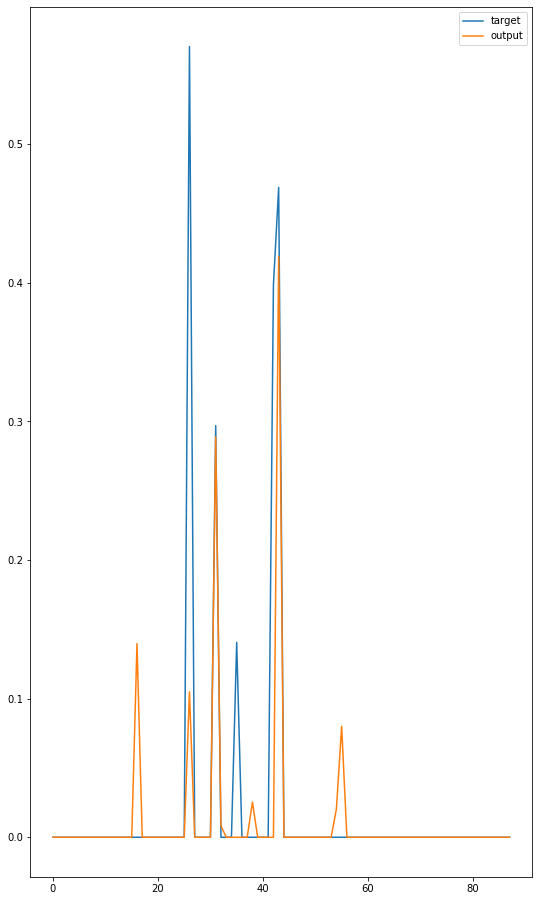

train loss: 0.005372463949633954, valid loss: 0.006025427943704842
train loss: 0.0057297365404839545, valid loss: 0.007029452892107384
train loss: 0.005926090936724828, valid loss: 0.006693351752707891


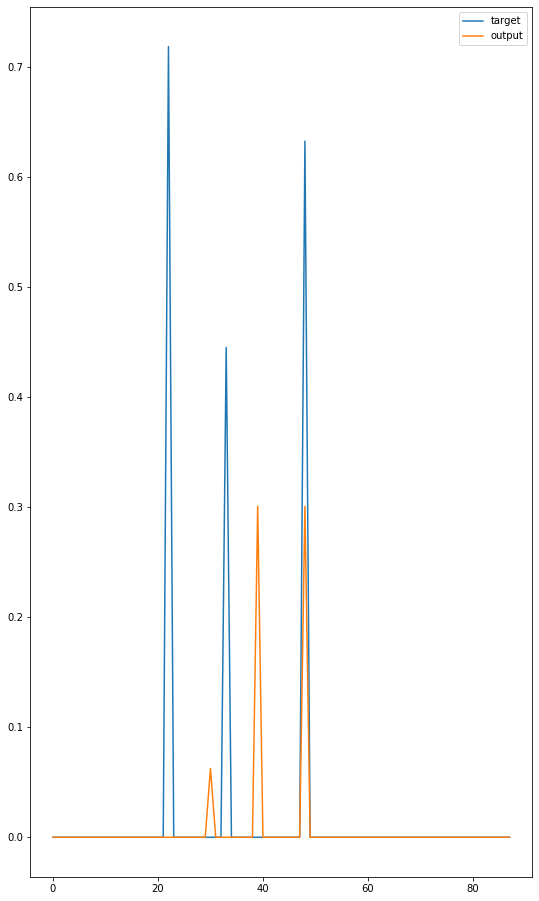

train loss: 0.004861525275687922, valid loss: 0.00566818264843983
train loss: 0.005122133869042394, valid loss: 0.006731210002310087
train loss: 0.005650713469149876, valid loss: 0.0060471010820887915


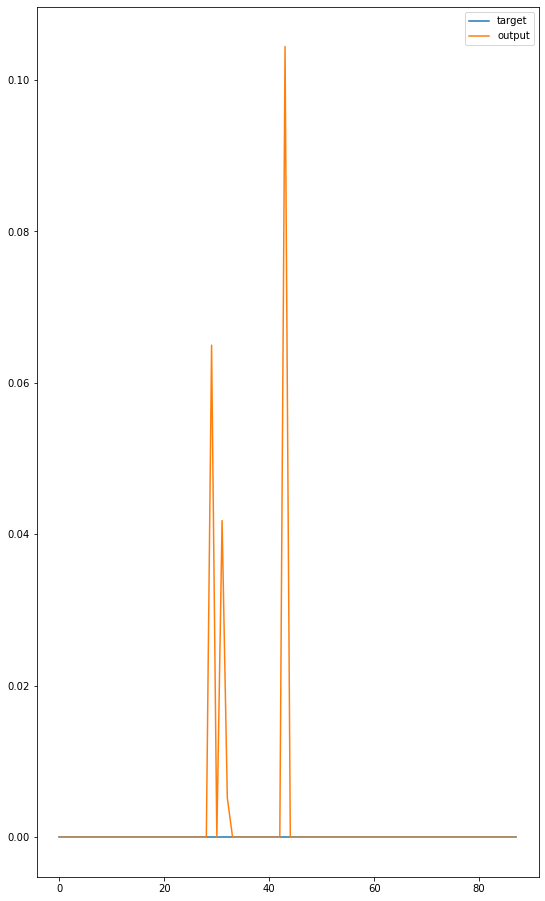

train loss: 0.006326361052326371, valid loss: 0.005216626237172668
train loss: 0.005331319149705433, valid loss: 0.006739876337488678
train loss: 0.005966032897644441, valid loss: 0.00544515082386331


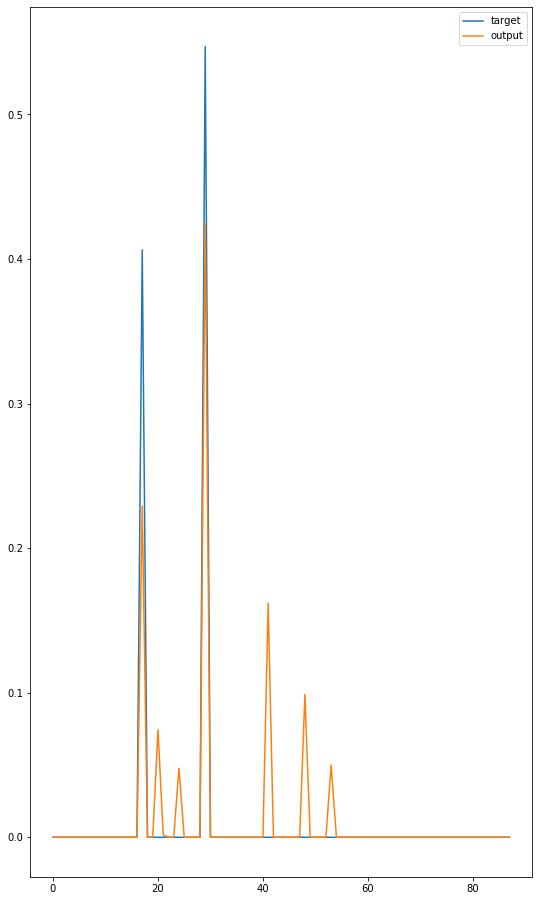

train loss: 0.00563953094462925, valid loss: 0.006134113875679045
train loss: 0.005434034691435921, valid loss: 0.005726693541890829
train loss: 0.005517445777751784, valid loss: 0.005901873546922318


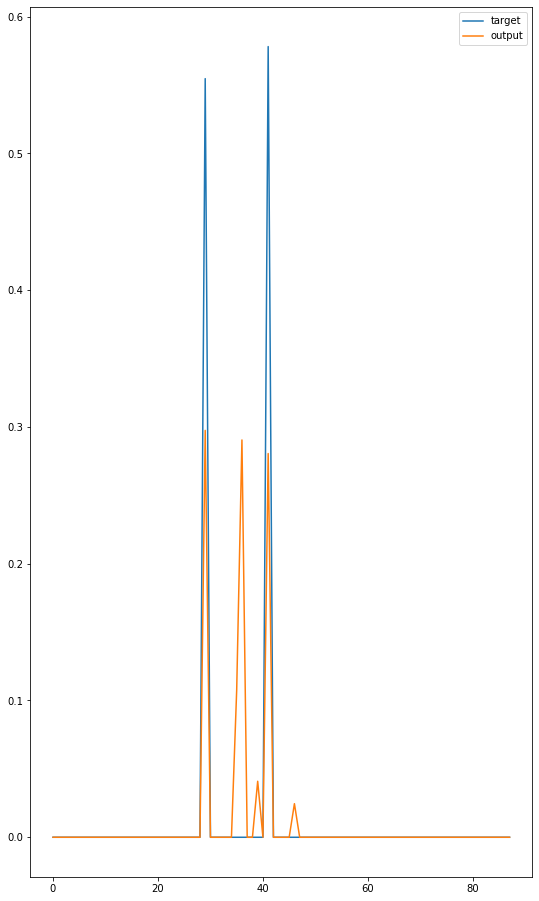

train loss: 0.005963409421791401, valid loss: 0.007220678579793355
train loss: 0.00583717730070386, valid loss: 0.005324803575629664
train loss: 0.005781020368579949, valid loss: 0.004753036098119533


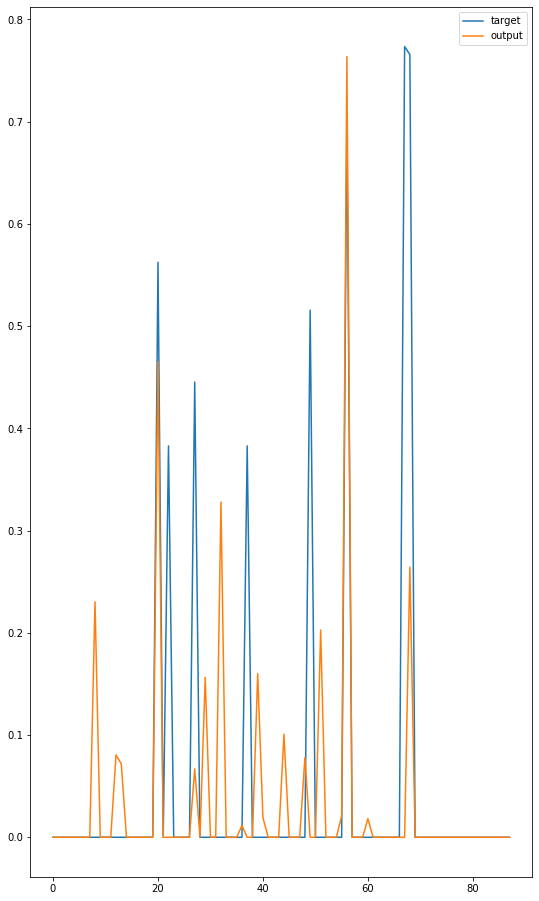

train loss: 0.006228654362505006, valid loss: 0.005754103427143576
train loss: 0.005886009730024385, valid loss: 0.005840563215315342
train loss: 0.0057318290558460855, valid loss: 0.005287762013237889


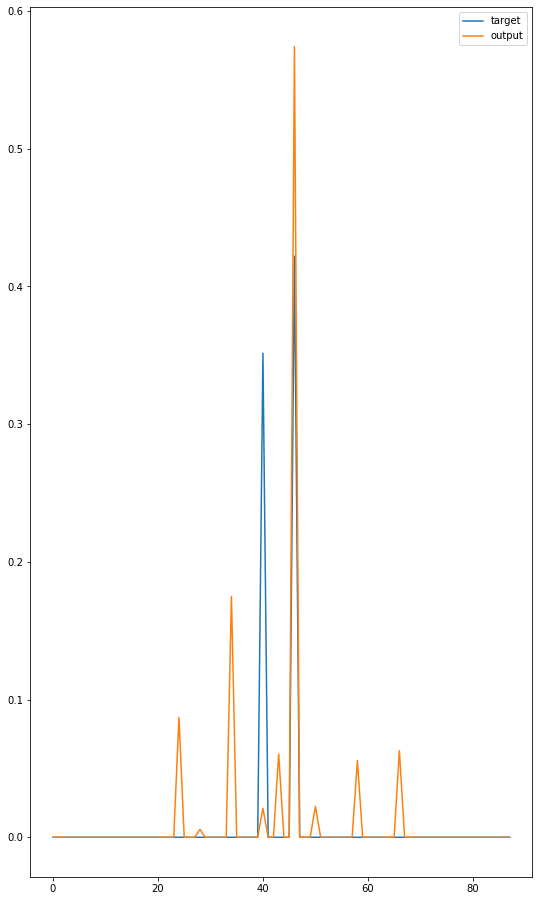

train loss: 0.005263823675313773, valid loss: 0.006839552789787266
train loss: 0.005257869537519378, valid loss: 0.00635682764054041
train loss: 0.005975789225129324, valid loss: 0.005862882543598937


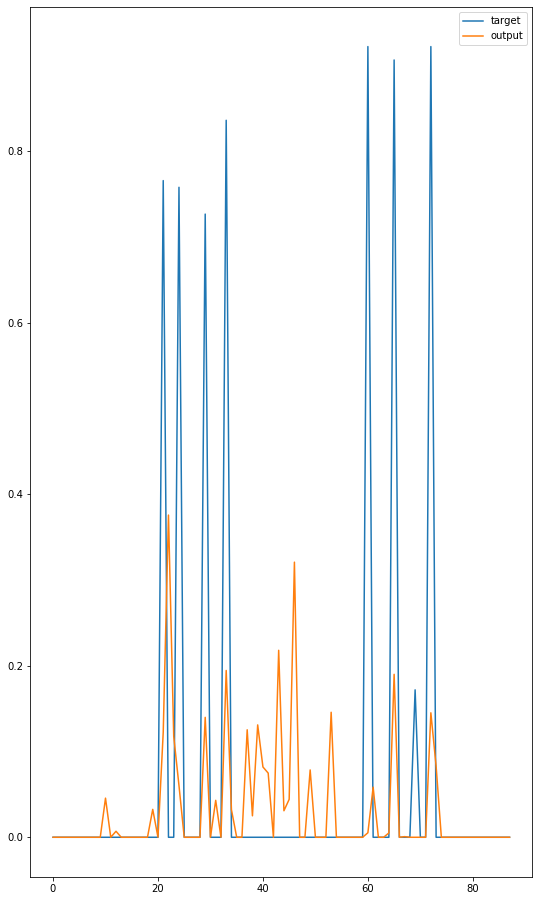

train loss: 0.00605223200906277, valid loss: 0.00702307837205791
train loss: 0.00591047852034637, valid loss: 0.005399622366911619
train loss: 0.005839892341015495, valid loss: 0.005257930045198893


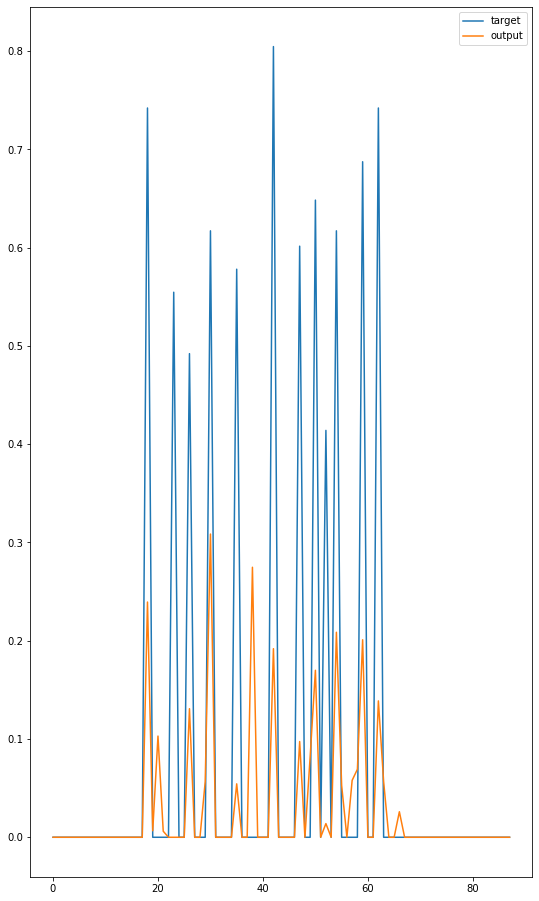

train loss: 0.0053421119358564645, valid loss: 0.007436386649018136
train loss: 0.005372733188897511, valid loss: 0.006639693245709499
train loss: 0.006095013910878415, valid loss: 0.005190012541329749


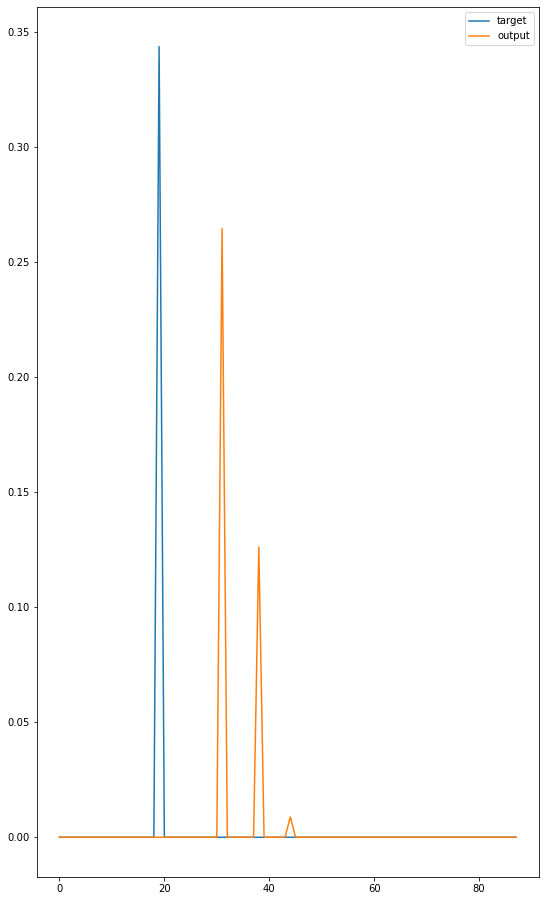

train loss: 0.005179247092107467, valid loss: 0.005727006823137821
train loss: 0.005259876347268783, valid loss: 0.005246494095946584
train loss: 0.005288545283810975, valid loss: 0.00786589686628257


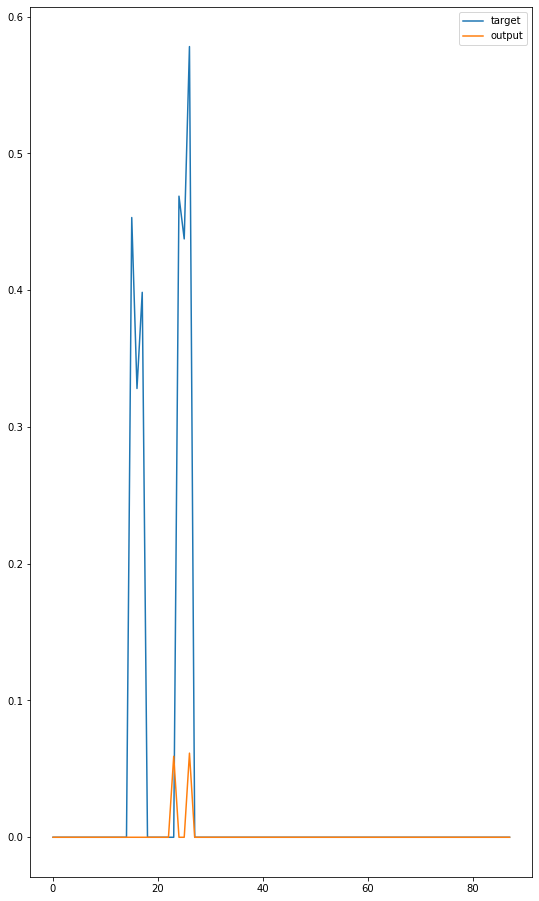

train loss: 0.005426372597255161, valid loss: 0.006303331953969514
train loss: 0.005583910803554284, valid loss: 0.005858170512680696
train loss: 0.005420998156627762, valid loss: 0.005675761716736254


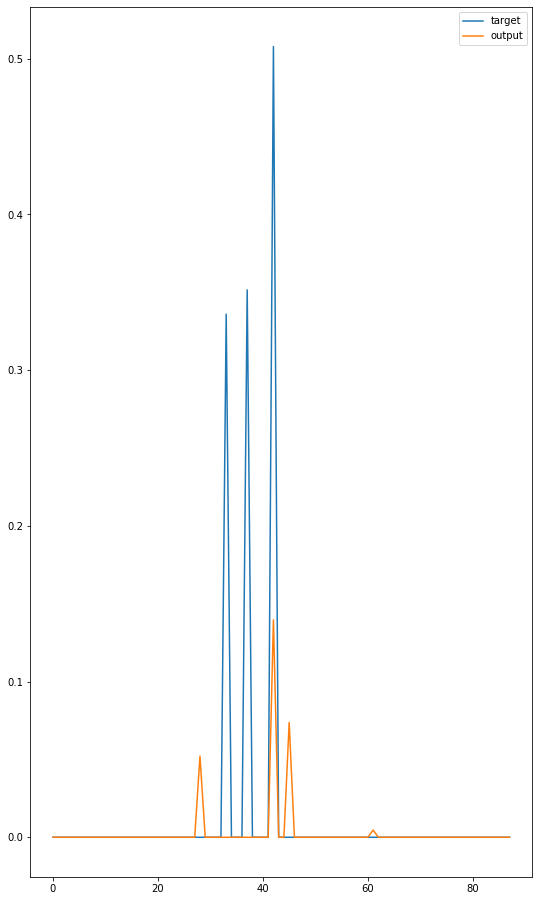

train loss: 0.005887665616122083, valid loss: 0.005819287442680553
train loss: 0.005131341668202707, valid loss: 0.007226955036798092
train loss: 0.005316884704064752, valid loss: 0.0048134576215922275


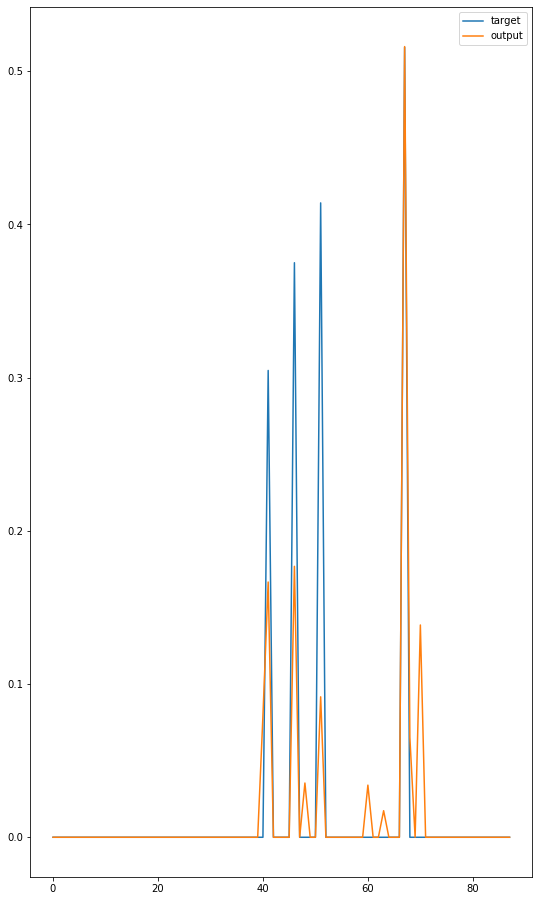

train loss: 0.004870889855278917, valid loss: 0.0062007464372735716
train loss: 0.005782393705987624, valid loss: 0.006547042564706546
train loss: 0.004940972179304982, valid loss: 0.00583240347174562


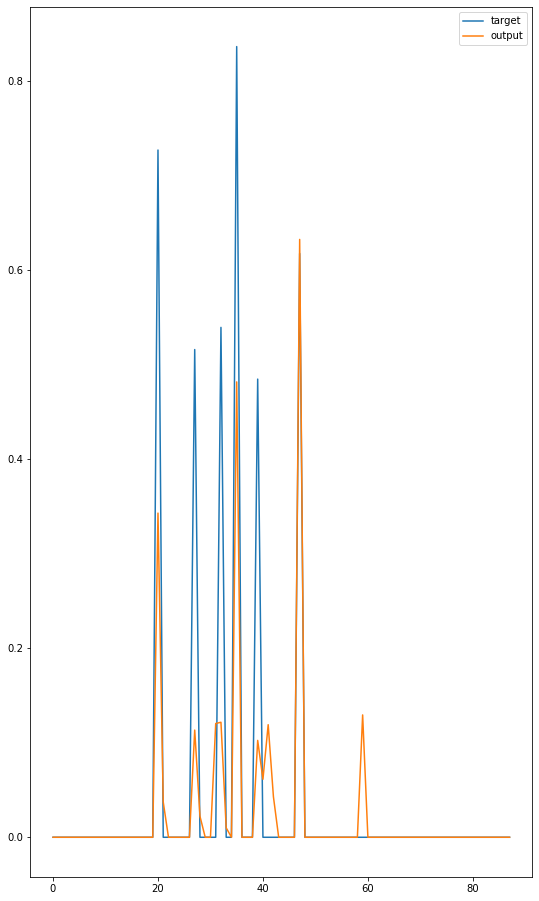

train loss: 0.006217480482638022, valid loss: 0.006416217593702479
train loss: 0.006079170462309827, valid loss: 0.006145296522598958
train loss: 0.005372217630588876, valid loss: 0.005530052848821767


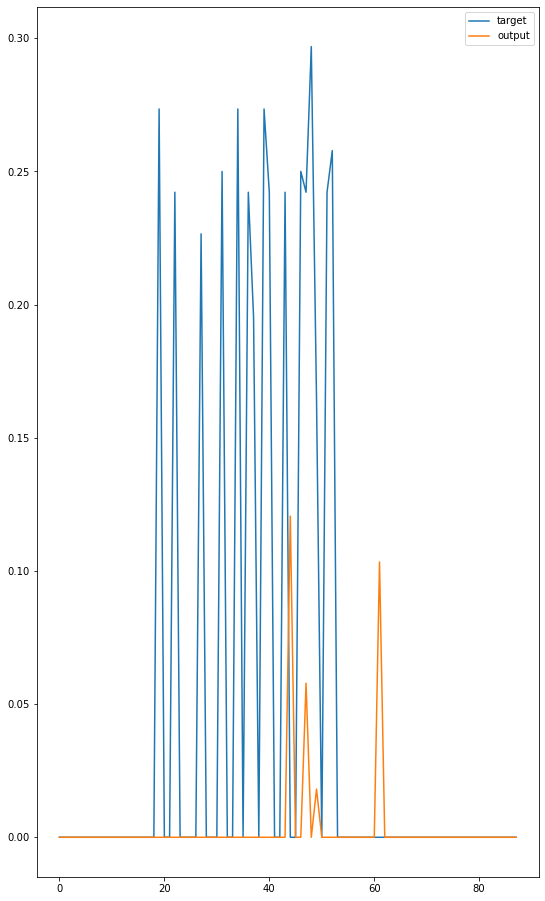

train loss: 0.005538006106426365, valid loss: 0.006752340375471895
train loss: 0.005502130141020448, valid loss: 0.006478488127587833
train loss: 0.00591373121339793, valid loss: 0.006609809645843283


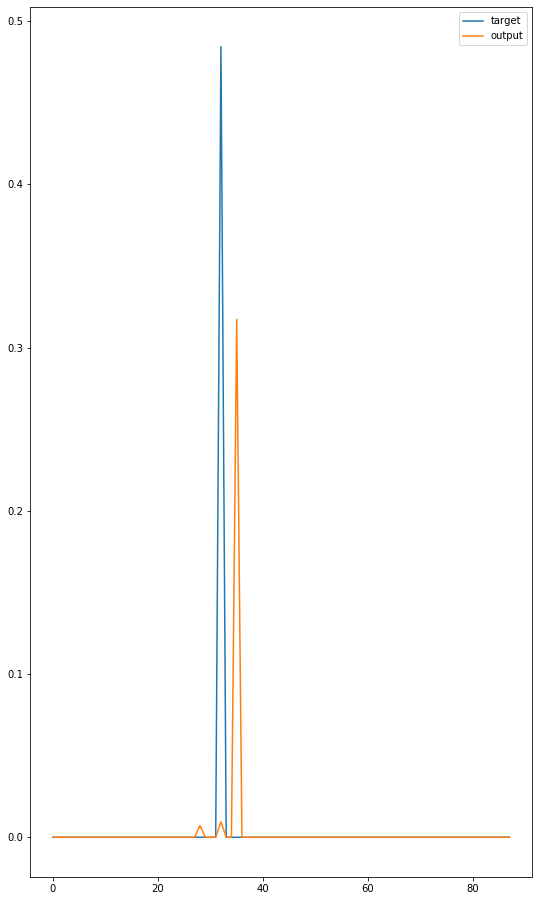

train loss: 0.00569941797054364, valid loss: 0.005363801146082789
train loss: 0.005780501615377926, valid loss: 0.007154438553256131
train loss: 0.005936071227705019, valid loss: 0.0062789702135199145


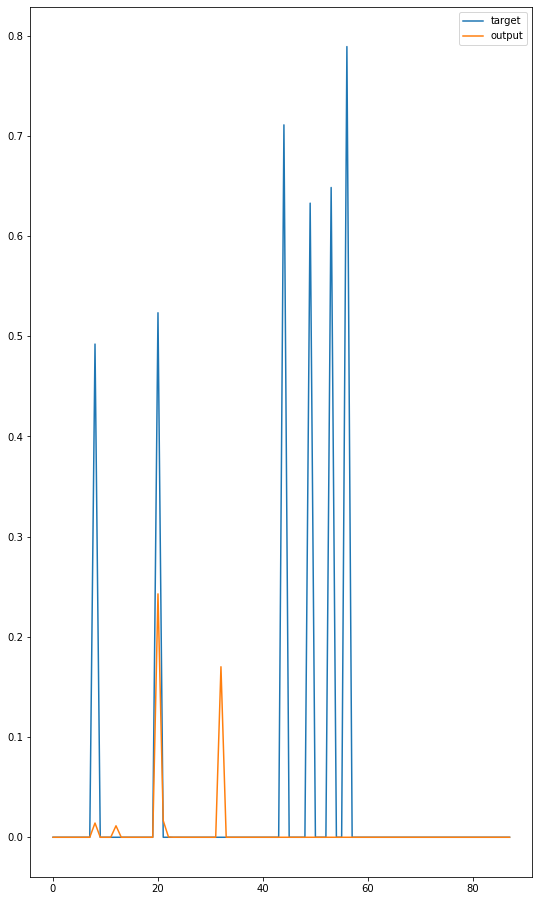

train loss: 0.0053943145234642605, valid loss: 0.00595065266781739
train loss: 0.005571870622877902, valid loss: 0.005911347882769933
train loss: 0.005785036186913951, valid loss: 0.007359199926570476


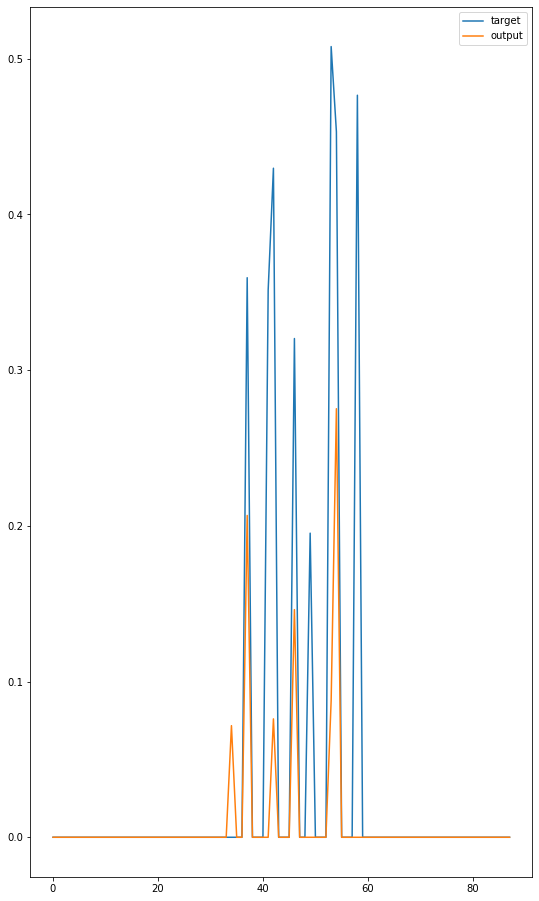

train loss: 0.00552292575050041, valid loss: 0.006507770950409854
train loss: 0.0055289687599690855, valid loss: 0.006035113528753831
train loss: 0.005413578185644523, valid loss: 0.005506586457524344


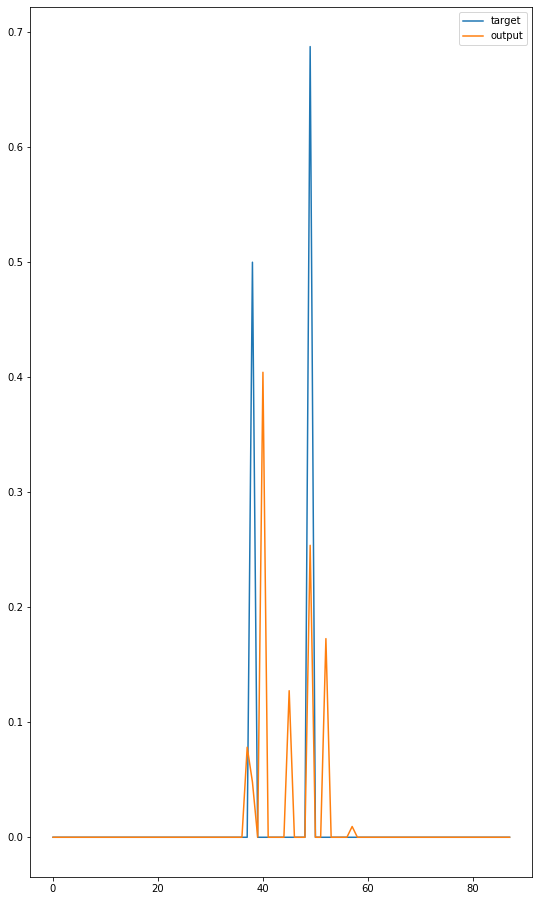

train loss: 0.005489992113810067, valid loss: 0.0061494234566376585
train loss: 0.005570800173113766, valid loss: 0.006304026333284434
train loss: 0.005255843449610277, valid loss: 0.005891074374248491


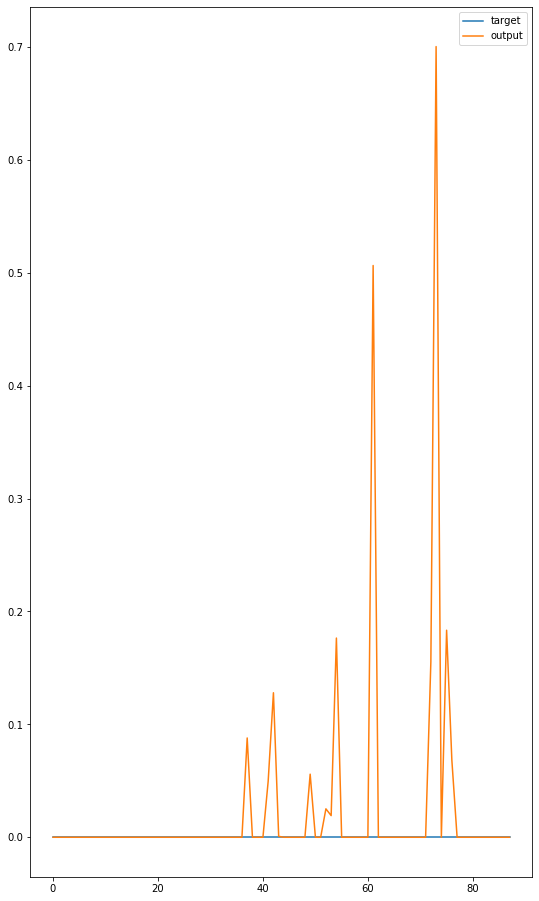

train loss: 0.005860995357664668, valid loss: 0.008749542383598947
train loss: 0.005239876388641788, valid loss: 0.0060162202968636405
train loss: 0.0053940522027524, valid loss: 0.005833261010942058


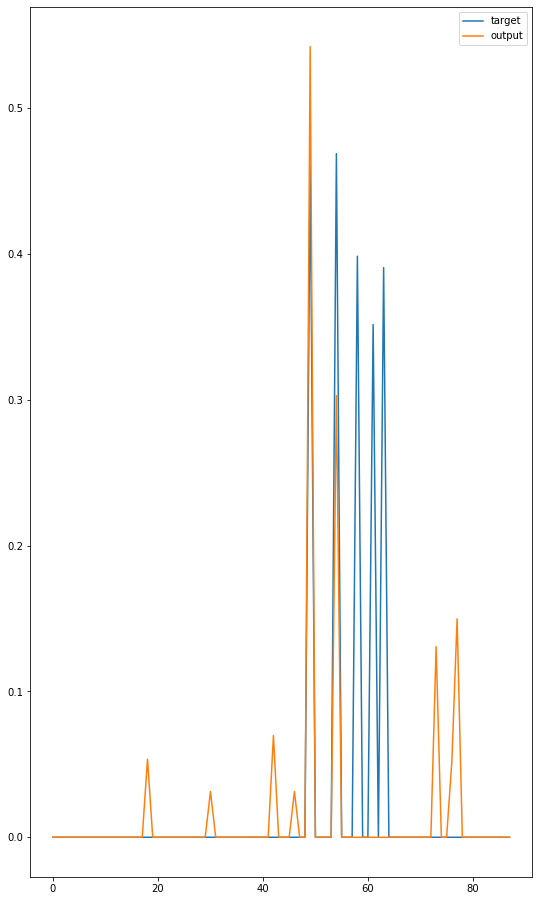

train loss: 0.0053625225566031635, valid loss: 0.006658212956319624
train loss: 0.005426683466420204, valid loss: 0.0060277141447866635
train loss: 0.006299163235534227, valid loss: 0.006160703727052869


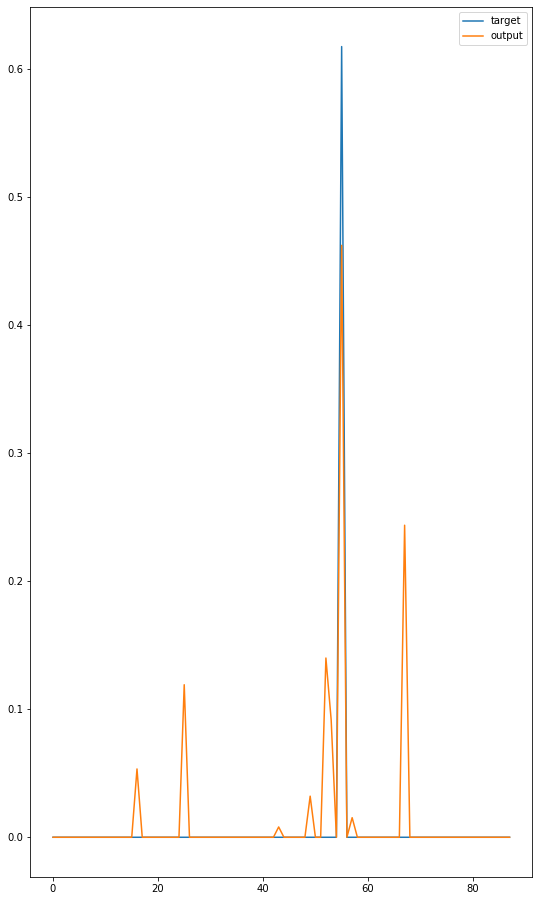

train loss: 0.005706736564453447, valid loss: 0.005904447204633572
train loss: 0.005570079124898206, valid loss: 0.0071848047609989335
train loss: 0.005845020211815277, valid loss: 0.006334702292822789


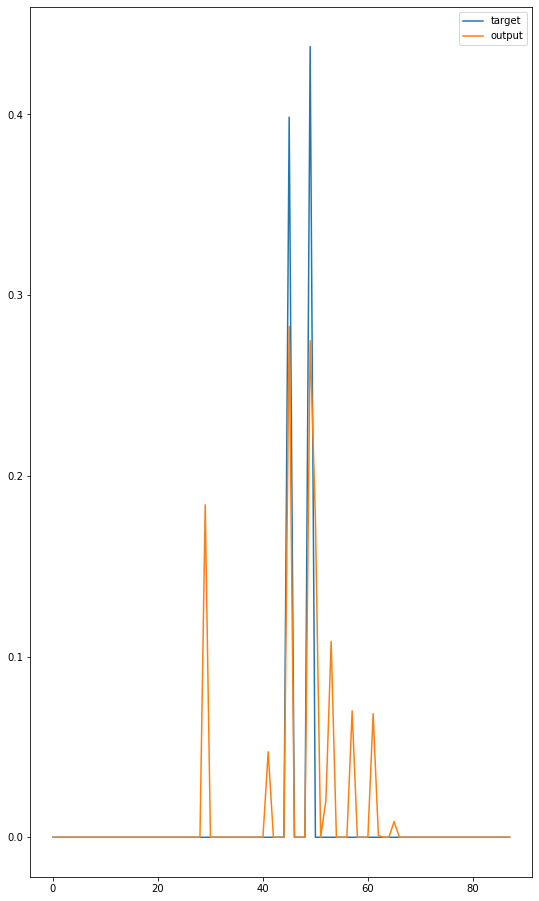

train loss: 0.005724201417336606, valid loss: 0.005798790986849883
train loss: 0.005213368465366695, valid loss: 0.005580001928469288
train loss: 0.0054181613992011855, valid loss: 0.005979572601233409


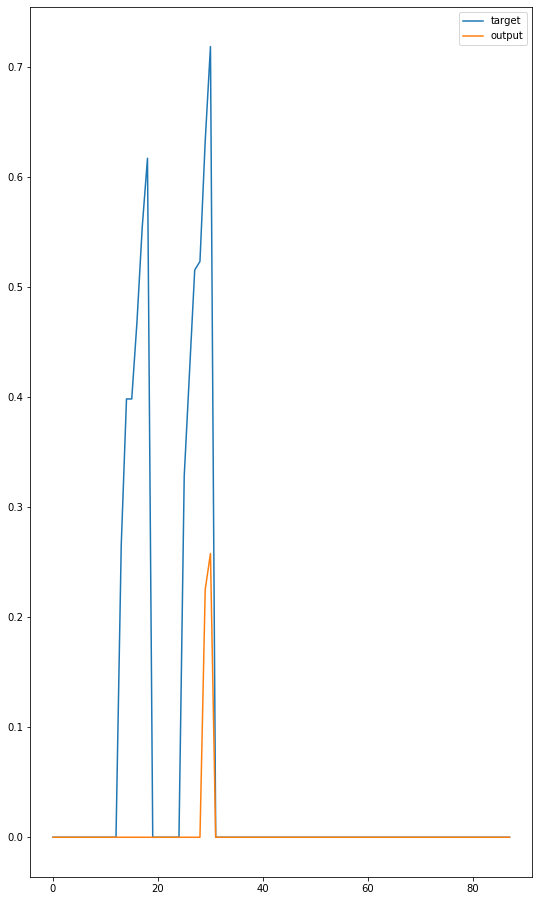

train loss: 0.00541658285748492, valid loss: 0.005857666819486941
train loss: 0.006022138508019325, valid loss: 0.007288816602569874
train loss: 0.004885548101759855, valid loss: 0.005924004486927362


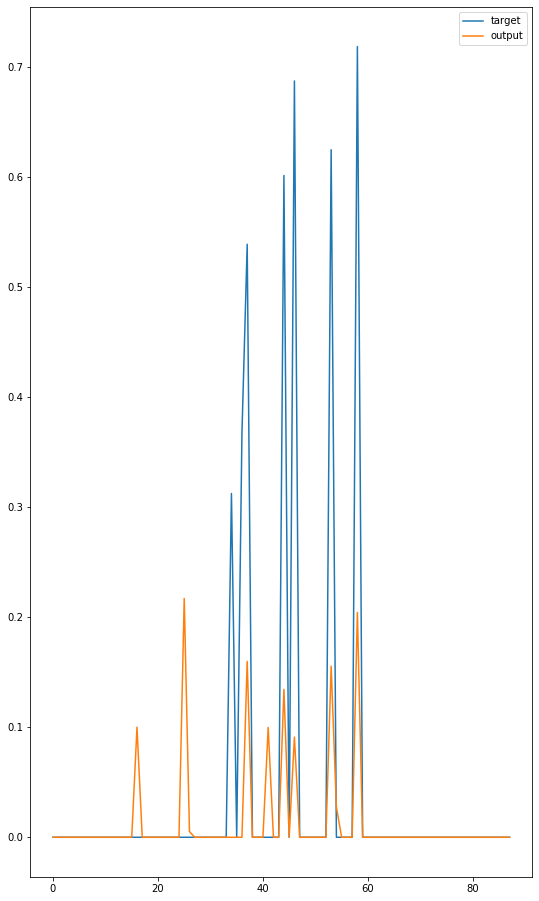

train loss: 0.005681536903509122, valid loss: 0.005825229002180222
train loss: 0.005626500104379918, valid loss: 0.006205506387784659
train loss: 0.005752669102251182, valid loss: 0.005822531104296725


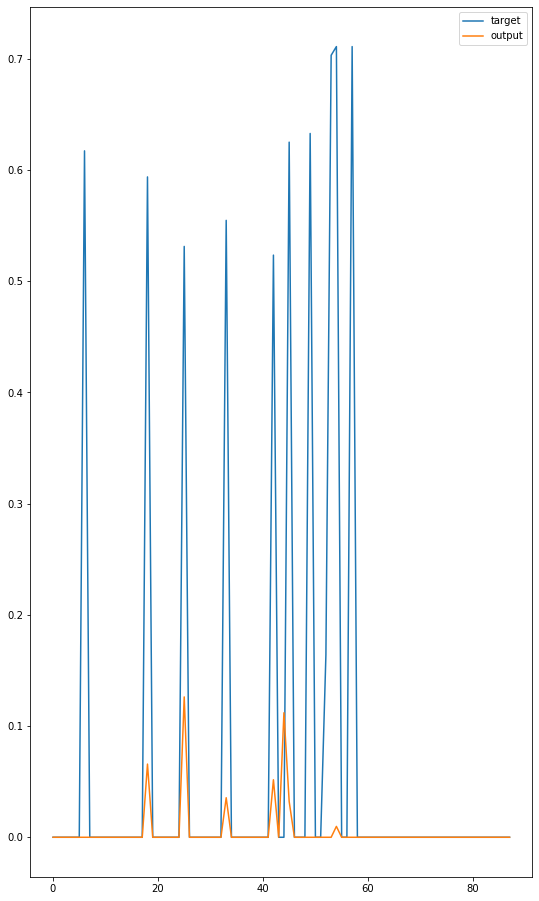

train loss: 0.0049053332953339565, valid loss: 0.00692208331931278
train loss: 0.005570641076888576, valid loss: 0.006390437418507917
train loss: 0.00505814326722523, valid loss: 0.006313939883469421


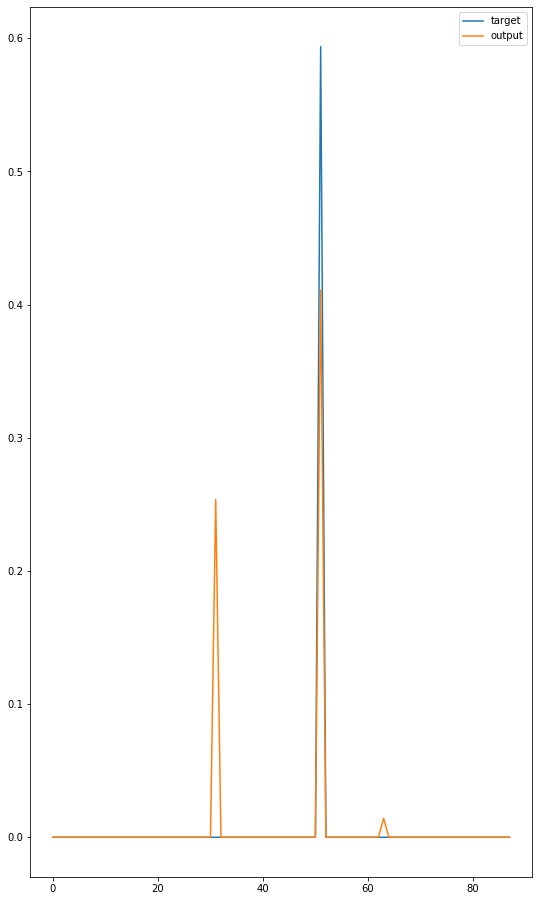

train loss: 0.005610150673478911, valid loss: 0.0071640506552131935
train loss: 0.0056982536845901445, valid loss: 0.005517326134352762
train loss: 0.005371495680970566, valid loss: 0.006564081394087489


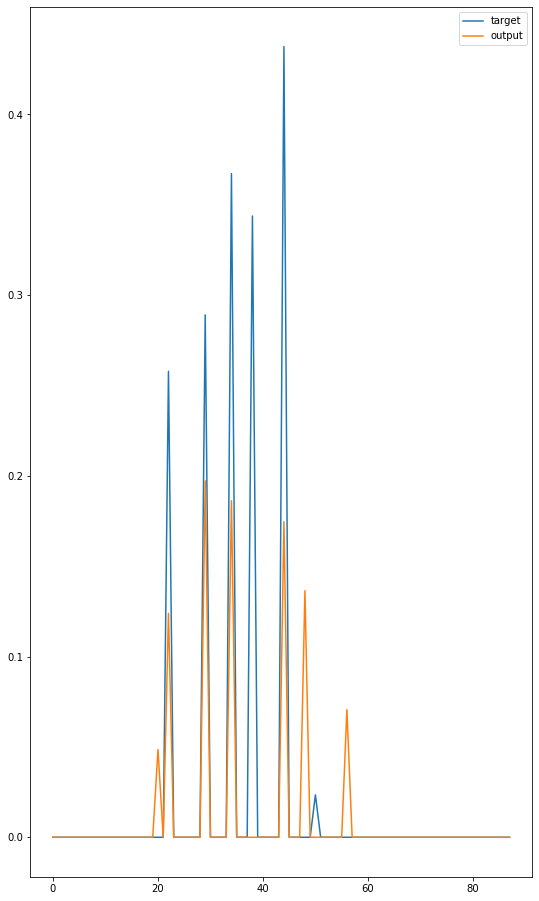

train loss: 0.00588840218130325, valid loss: 0.006710718760145045
train loss: 0.00565883138208328, valid loss: 0.006494267730512352
train loss: 0.005588294524769081, valid loss: 0.007742941074908894


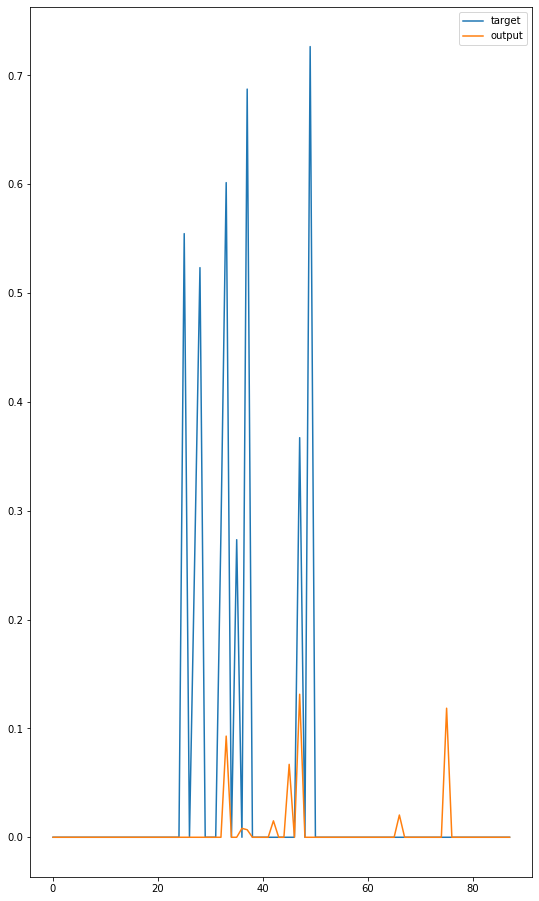

train loss: 0.0054881006248608645, valid loss: 0.007121388482748069
train loss: 0.0056361090250435135, valid loss: 0.005742772034082179
train loss: 0.005632671373069426, valid loss: 0.005576194285754567


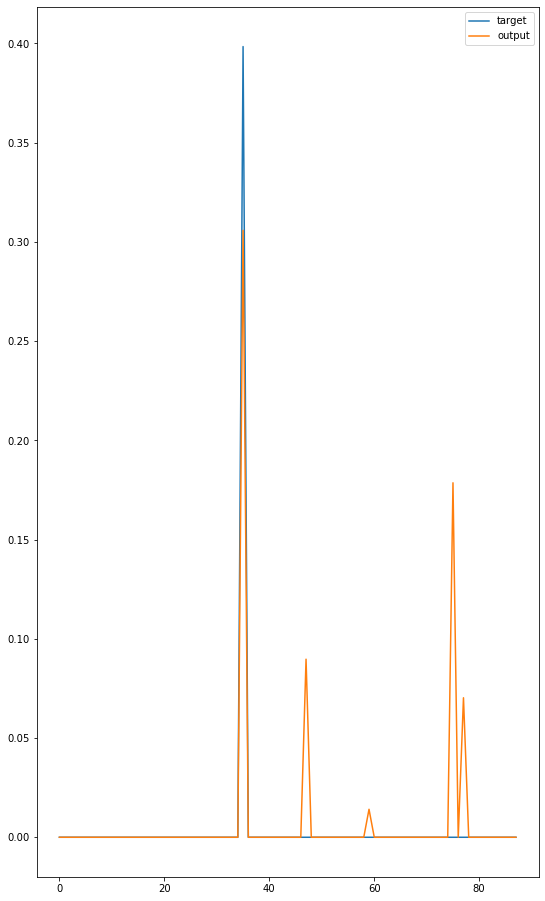

train loss: 0.005412434568850619, valid loss: 0.006101095835704391
train loss: 0.005123511199386808, valid loss: 0.007451611296839525
train loss: 0.005608888719422377, valid loss: 0.005625854494380895


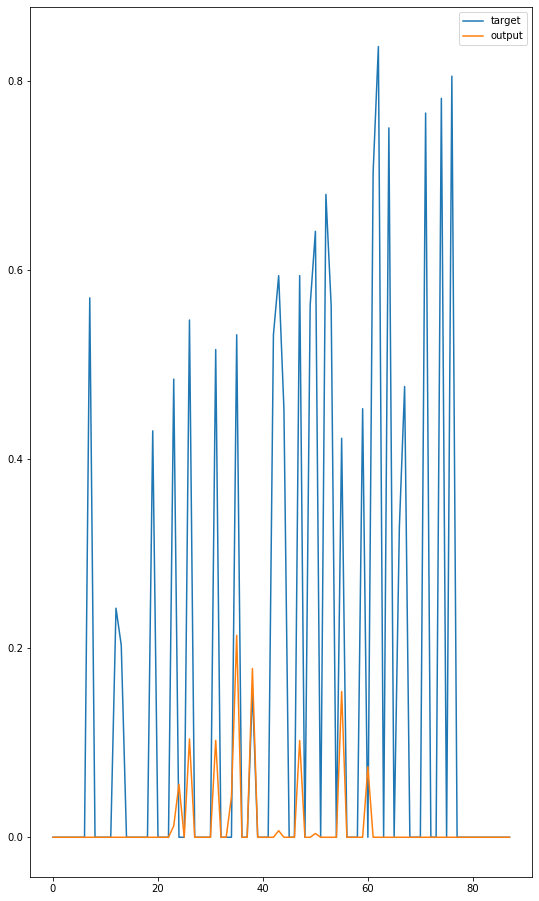

train loss: 0.005171072145458311, valid loss: 0.006139952058372932
train loss: 0.0059270759604906085, valid loss: 0.006354546074311588
train loss: 0.005509131482506397, valid loss: 0.007216436518617322


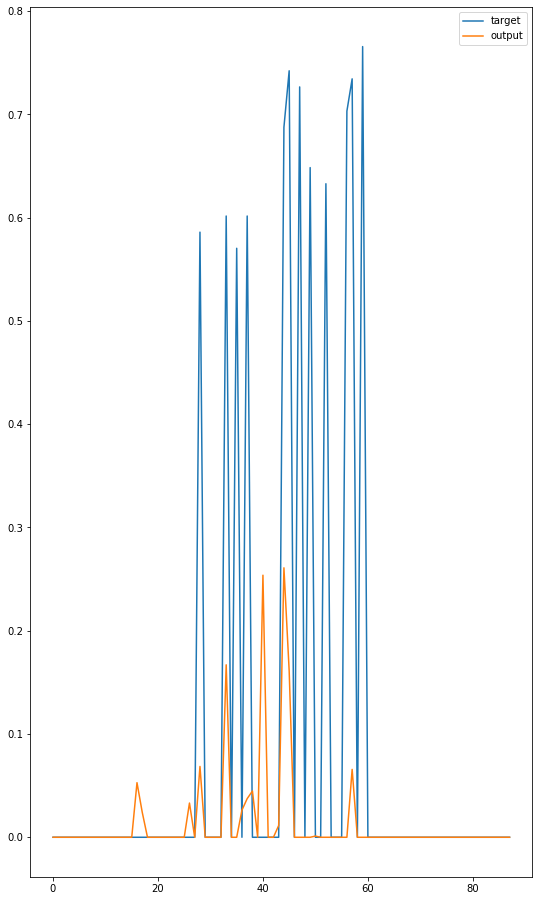

train loss: 0.005576046245720969, valid loss: 0.005322743128880719
train loss: 0.00585550242147156, valid loss: 0.005708470757806969
train loss: 0.0056316581245720665, valid loss: 0.005800029497906984


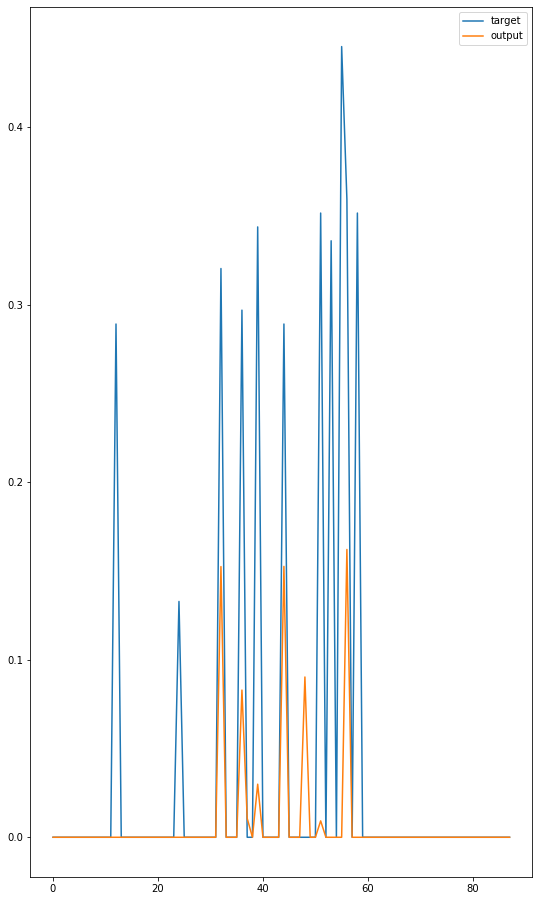

train loss: 0.005493301121413568, valid loss: 0.005511312175402853
train loss: 0.005451337297264242, valid loss: 0.007351741943264676
train loss: 0.006036461026312035, valid loss: 0.004947061149977914


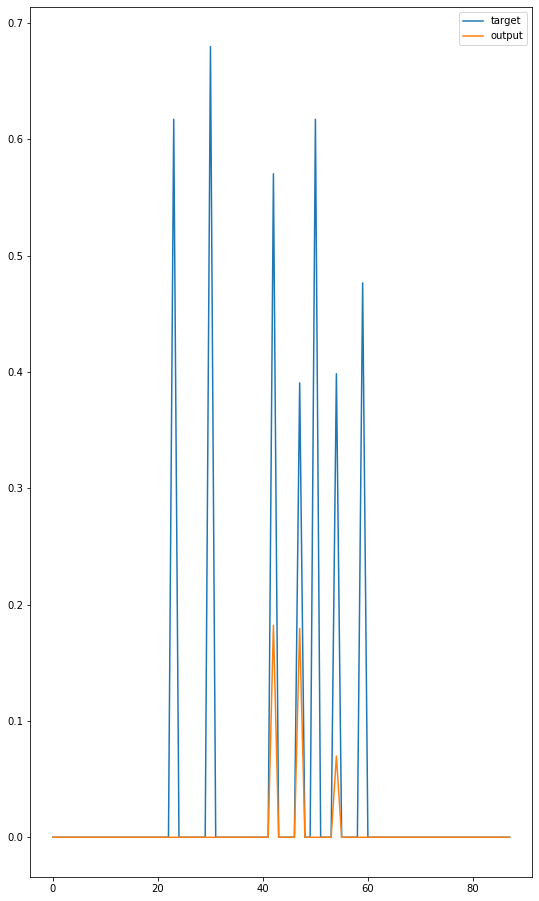

train loss: 0.005212846484087477, valid loss: 0.006568154594295214
train loss: 0.004951653104475656, valid loss: 0.0057340494887990374
train loss: 0.005155557451038578, valid loss: 0.006586675714945125


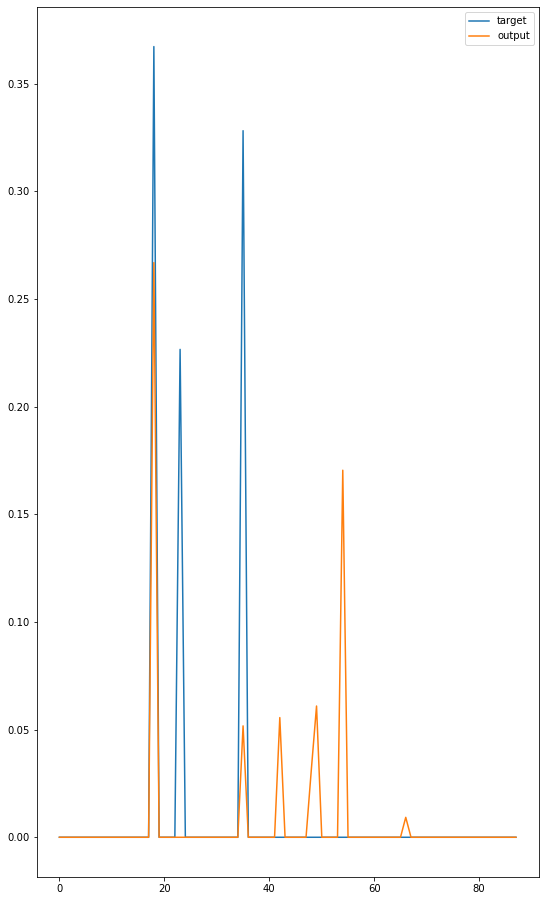

train loss: 0.005254115822298505, valid loss: 0.005700552683741411
train loss: 0.005614684129821432, valid loss: 0.005491645005749207
train loss: 0.005618317094065736, valid loss: 0.007395777464017411


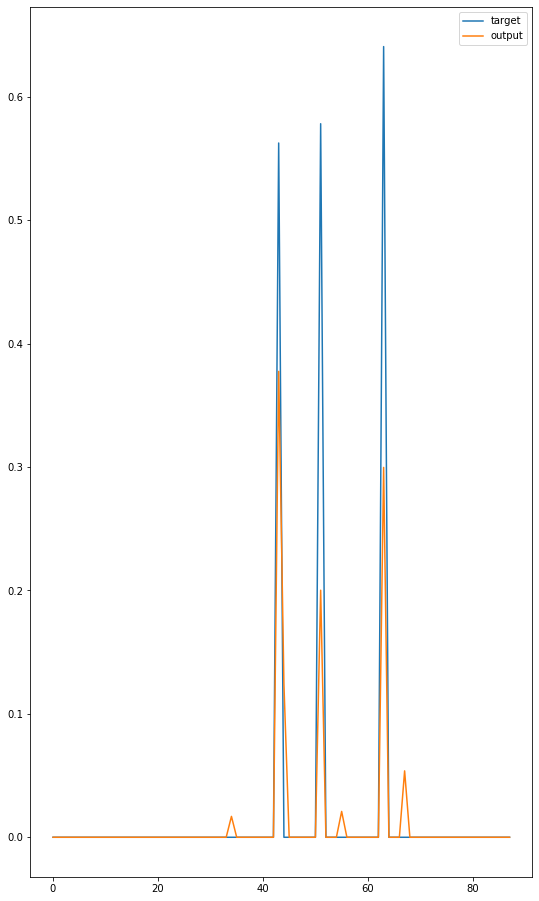

train loss: 0.005739699949066494, valid loss: 0.005667779307429479
train loss: 0.005575495871071155, valid loss: 0.006885878328303589
train loss: 0.005589894790454793, valid loss: 0.005040998479229546


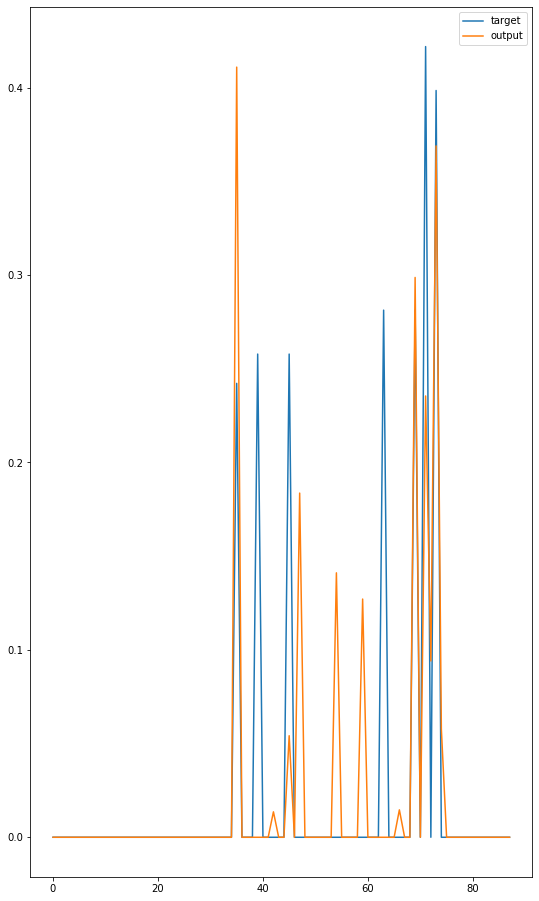

train loss: 0.005690068515696537, valid loss: 0.00658392607643504
train loss: 0.005284171601513696, valid loss: 0.00571405890650142
train loss: 0.005956691415614892, valid loss: 0.006784747128383579


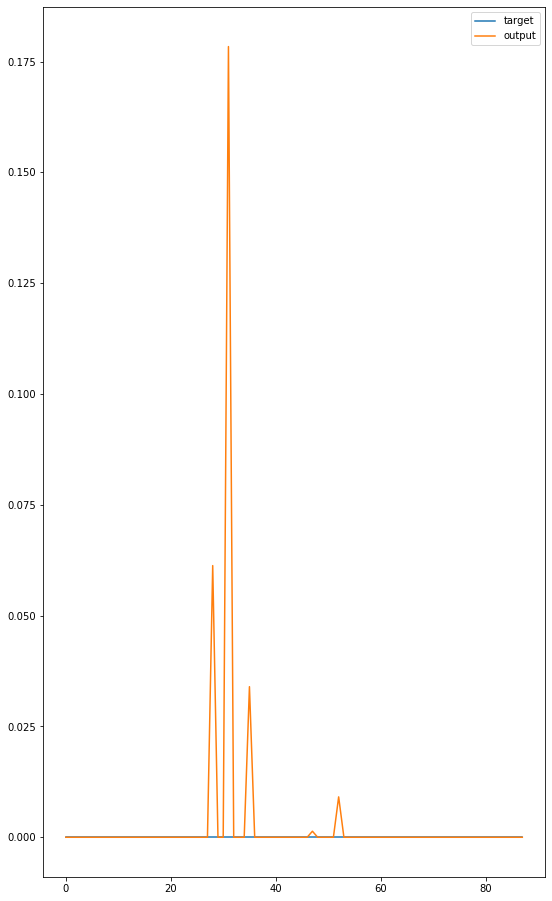

train loss: 0.005540736026139321, valid loss: 0.005520264204661144
train loss: 0.005206195998797628, valid loss: 0.006633437669479123
train loss: 0.0053899492763818425, valid loss: 0.0053938421351121405


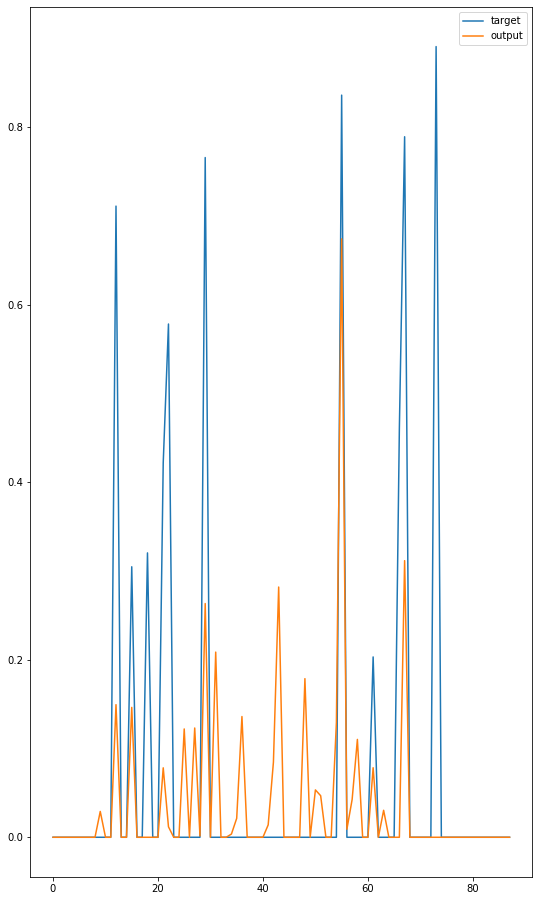

train loss: 0.006081784503081831, valid loss: 0.006341114531436535
train loss: 0.005346982084893596, valid loss: 0.005296884609438548
train loss: 0.005442223649811452, valid loss: 0.005776149760409494


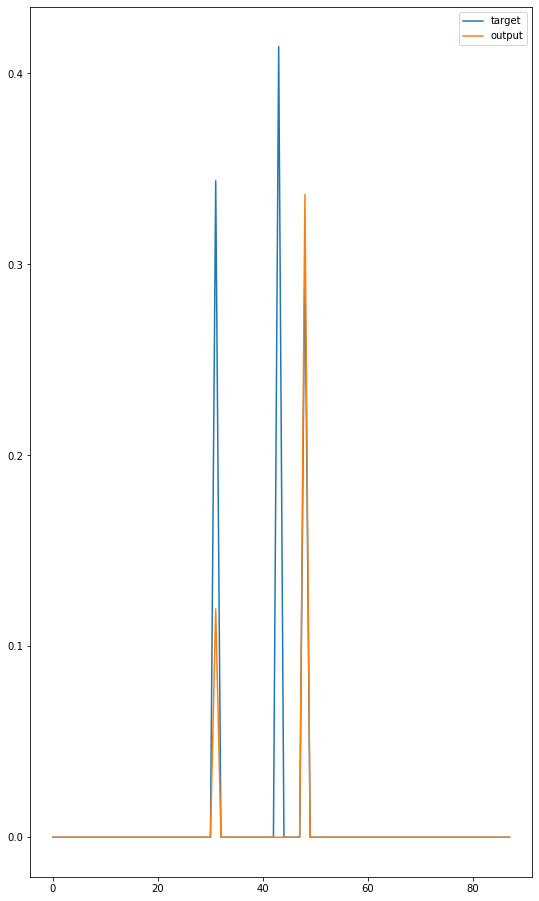

train loss: 0.0051174033248240006, valid loss: 0.005413584028170488
train loss: 0.00541212796298874, valid loss: 0.006789948669410198
train loss: 0.005475619616352509, valid loss: 0.007469233978435258


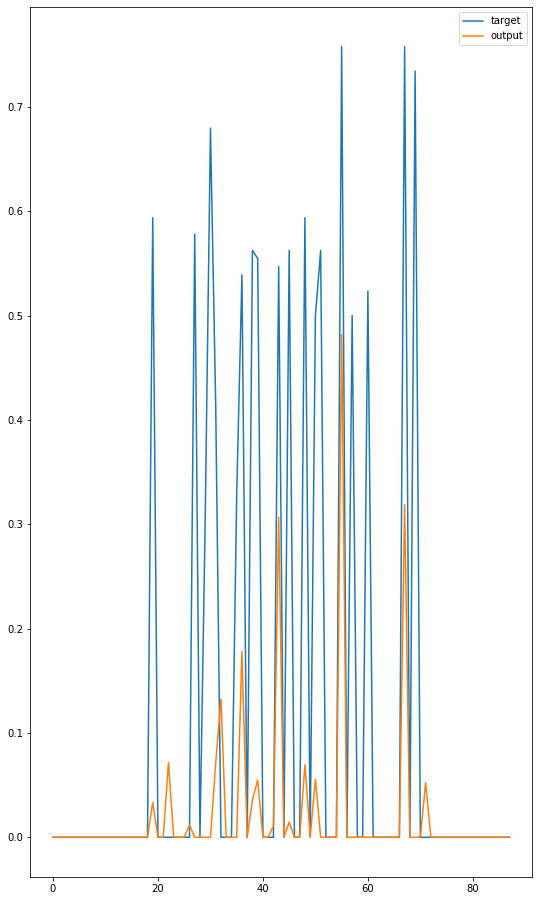

train loss: 0.005182075259824084, valid loss: 0.006103996626997941
train loss: 0.005252948706473494, valid loss: 0.007314648283384392
train loss: 0.005342575354788835, valid loss: 0.005673706444485165


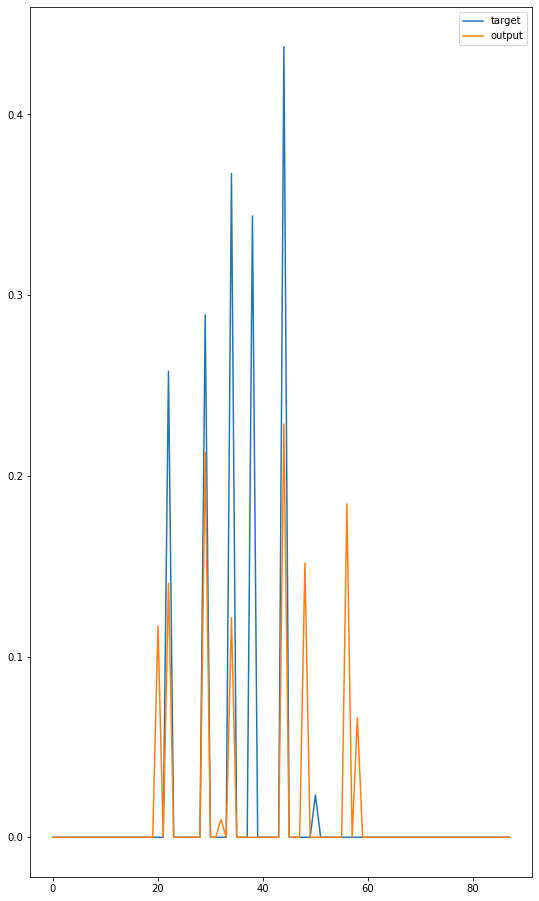

train loss: 0.005163839156521815, valid loss: 0.006546211050318502
train loss: 0.005171020716541908, valid loss: 0.006154750569540763
train loss: 0.005161884646627739, valid loss: 0.00574078254192789


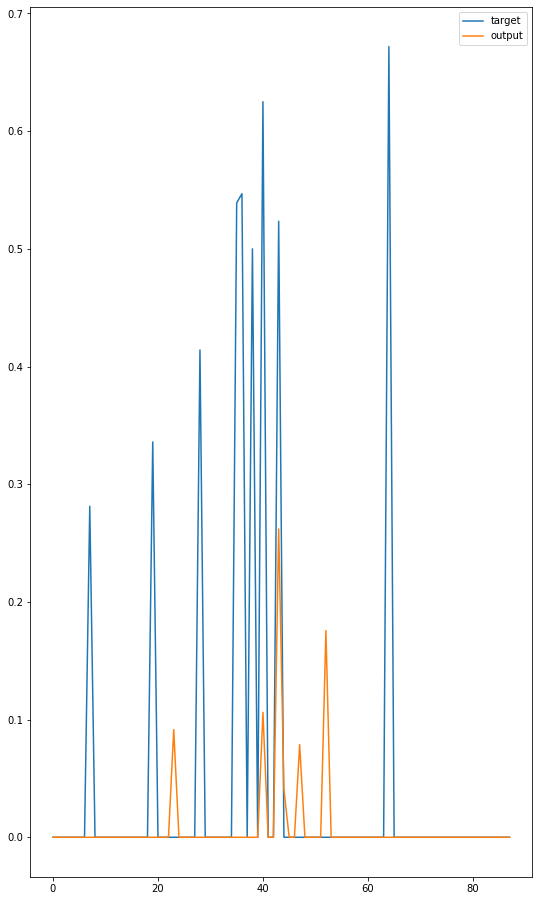

train loss: 0.005576202621962005, valid loss: 0.005360807192067955
train loss: 0.0051163039556443345, valid loss: 0.005493330938967867
train loss: 0.005123605494709494, valid loss: 0.007211274428240886


In [25]:
n_epochs = 300
lr = 2e-5

train_ls = []
valid_ls = []

m = Audio2Midi(kernel_size=9)
m = m.cuda()
optim = torch.optim.Adam(params=m.parameters(), lr=lr)
critereon = nn.MSELoss()

mb = master_bar(range(n_epochs))
mb.names = ['train', 'valid']
for e in mb:
    m.train()
    tl = 0
    for idx,it in enumerate(progress_bar(train_dl, parent=mb)):
        audio, target = melspectrogram(it["audio"]), it["velocity"]
        for seg in range(target.shape[2]):
            out = m(audio.cuda()[:,:,seg].unsqueeze(1))
            l = critereon(out, target.cuda()[:,seg,:])
            l.backward()
            optim.step()
            tl += l.detach().cpu().item()
            m.zero_grad()
            
            
            if seg == 0 and idx == 0 and e%3==0:
                plt.figure()
                plt.plot(target[1,1,:], label="target")
                plt.plot(out[1,:].detach().cpu(), label="output")
                plt.legend()
                plt.show()
    tl /= len(train_ds)
    train_ls.append(tl)
    with torch.no_grad():
        vl = 0
        for it in progress_bar(valid_dl, parent=mb):
            audio, target = melspectrogram(it["audio"]), it["velocity"]
            for seg in range(target.shape[2]):
                out = m(audio.cuda()[:,:,seg].unsqueeze(1))
                l = critereon(out, target.cuda()[:,seg,:])
                vl += l.detach().cpu().item()
        vl /= len(valid_ds)
        valid_ls.append(vl)
    mb.update_graph([[range(e+1), train_ls], [range(e+1), valid_ls]])
    print(f"train loss: {tl}, valid loss: {vl}")
torch.save(m.state_dict(), f"models/{n_epochs}_{lr}.pth")

In [ ]:
from MelodyMatrix import *

In [ ]:
lvectest = torch.randn(88, 1)
rvectest = torch.randn(88, 1)

In [2]:
%%writefile make_frame.py

def make_frame(l_vec, r_vec, genre, thresh):
    """
    Creates a frame for visualization stack out of left and right machine learning outputs
    Arguments:
        l_vec: velocity vector for left channel
        r_vec: velocity vector for right channel
        genre: genre to pass through to frame
        thresh: velocity value under which to ignore note
    """
    notes = []
    
    pans = r_vec / l_vec
    pans /= max(pans)
    pans *= 127
    velocities = [max(l_vec[i,0], r_vec[i,0]) for i in range(l_vec.shape[0])]
    for pitch,vel,pan in zip(range(l_vec.shape[0]), velocities, pans):
        if vel > thresh:
            notes.append(Note(pitch, vel, pans[pitch]))
        
    print()
    frame = Frame(notes, genre)
    return frame

Writing make_frame.py


In [22]:
f = make_frame(lvectest, rvectest, Genre('Pop'), 1)

In [23]:
len(f.notes)

19